# Bipartite Network: Companies and Investors

In [280]:
# Standard Library Imports
import hashlib
import math
import os
import pickle
import random
import re
import string
from collections import Counter, defaultdict

# Third-Party Libraries
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from wordcloud import WordCloud
from networkx.algorithms import bipartite
from networkx.algorithms.community import louvain_communities
from networkx import forceatlas2_layout
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from scipy import sparse

## Load and Explore Data

In [281]:
# Load the data
df = pd.read_csv('anonymized_network_data.csv')
print(f"Total rows: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print('\nSample Data:')
df.head()

Total rows: 62323

Columns: ['Deal ID', 'Companies', 'Company ID', 'Description_deal', 'Description_investor', 'Primary Industry Sector_deal', 'Primary Industry Group_deal', 'Primary Industry Code_deal', 'Keywords_deal', 'Investors', 'Lead/Sole Investors', 'Primary Investor Type', 'Preferred Industry']

Sample Data:


Deal ID        Companies Company ID  \
0  304086-16T    Horizon Drive  CID_00000   
1  303876-37T     Eco Modeling  CID_00001   
2  303464-53T  Meteor TechBase  CID_00002   
3  303125-86T    Blaze Science  CID_00003   
4  303116-68T      Bronze Soft  CID_00004   

                                    Description_deal Description_investor  \
0  Developer of a global healthcare provider sear...                  NaN   
1  Developer and manufacturer of semiconductor pr...                  NaN   
2  Manufacturer of material technologies intended...                  NaN   
3  Developer of large language models designed to...                  NaN   
4  Provider of digital infrastructure tools desig...                  NaN   

           Primary Industry Sector_deal    Primary Industry Group_deal  \
0                            Healthcare  Healthcare Technology Systems   
1                Information Technology                 Semiconductors   
2  Business Products and Services (B2B)            Commercial Products   
3                Information Technology                       Software   
4                Information Technology                       Software   

            Primary Industry Code_deal  \
0  Other Healthcare Technology Systems   
1                 Other Semiconductors   
2        Industrial Supplies and Parts   
3    Software Development Applications   
4       Business/Productivity Software   

                                       Keywords_deal       Investors  \
0  comparison data, digital health solutions, doc...   Joseph Torres   
1  circuit fabrication, processing equipment, sem...     John Wright   
2  composite manufacturers, composite materials, ...  Erik Magnussen   
3  ai capabilities, ai model, ai software develop...    Keith Miller   
4  asset management, content delivery, creative w...    Arvid Morris   

   Lead/Sole Investors Primary Investor Type Preferred Industry  
0                    0                   NaN                NaN  
1                    0                   NaN                NaN  
2                    0                   NaN                NaN  
3                    1                   NaN                NaN  
4                    0                   NaN                NaN

In [282]:
# Check for missing values in key columns
print("Missing values in key columns:")
print(df[['Companies', 'Investors', 'Description_deal', 'Description_investor']].isnull().sum())

Missing values in key columns:
Companies                   0
Investors                   0
Description_deal            0
Description_investor    54233
dtype: int64


In [283]:
print("\nUnique Primary Industry Sector:", df['Primary Industry Sector_deal'].nunique())
print("\nUnique Primary Industry Group:", df['Primary Industry Group_deal'].nunique())
print("\nUnique Primary Industry Code:", df['Primary Industry Code_deal'].nunique())



Unique Primary Industry Sector: 7

Unique Primary Industry Group: 41

Unique Primary Industry Code: 199


## Prepare Node Attributes

In [284]:
# Prepare company attributes
company_attrs = df.groupby('Companies').agg({
    'Description_deal': 'first',
    'Primary Industry Sector_deal': 'first',
    'Primary Industry Group_deal': 'first',
    'Primary Industry Code_deal': 'first'
}).to_dict('index')

print(f"Number of unique companies: {len(company_attrs)}")

Number of unique companies: 13614


In [285]:
# Prepare investor attributes
investor_attrs = df.groupby('Investors').agg({
    'Description_investor': 'first',
    'Lead/Sole Investors': 'sum',  # Sum of lead/sole investments
    'Primary Investor Type': 'first',
    'Preferred Industry': 'first'
}).to_dict('index')

print(f"Number of unique investors: {len(investor_attrs)}")

Number of unique investors: 31753


## Build Bipartite Network

In [286]:
# Create bipartite graph
B = nx.Graph()

# Add company nodes with attributes
for company, attrs in company_attrs.items():
    B.add_node(company, 
               bipartite=0,  # Companies are in set 0
               node_type='company',
               description=attrs['Description_deal'],
               sector=attrs['Primary Industry Sector_deal'],
               industry_group=attrs['Primary Industry Group_deal'],
               industry_code=attrs['Primary Industry Code_deal'])

# Add investor nodes with attributes
for investor, attrs in investor_attrs.items():
    B.add_node(investor,
               bipartite=1,  # Investors are in set 1
               node_type='investor',
               description=attrs['Description_investor'],
               lead_sole_count=attrs['Lead/Sole Investors'],
               investor_type=attrs['Primary Investor Type'],
               preferred_industry=attrs['Preferred Industry'])

print(f"Total nodes: {B.number_of_nodes()}")
print(f"Companies: {len(company_attrs)}")
print(f"Investors: {len(investor_attrs)}")

Total nodes: 45367
Companies: 13614
Investors: 31753


In [287]:
# Count investments (edges with weights)
edge_weights = df.groupby(['Companies', 'Investors']).size().reset_index(name='weight')

# Add weighted edges
for _, row in edge_weights.iterrows():
    B.add_edge(row['Companies'], row['Investors'], weight=row['weight'])

print(f"Total edges: {B.number_of_edges()}")
print(f"\nEdge weight statistics:")
print(edge_weights['weight'].describe())

Total edges: 57395

Edge weight statistics:
count    57395.000000
mean         1.085861
std          0.304594
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: weight, dtype: float64


## Verify Bipartite Structure

In [288]:
# Verify it's bipartite
print(f"Is bipartite: {bipartite.is_bipartite(B)}")

# Get the two sets
companies = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
investors = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}

print(f"\nCompany nodes: {len(companies)}")
print(f"Investor nodes: {len(investors)}")

Is bipartite: True

Company nodes: 13614
Investor nodes: 31753


## Beautiful Bipartite Sample Visualization

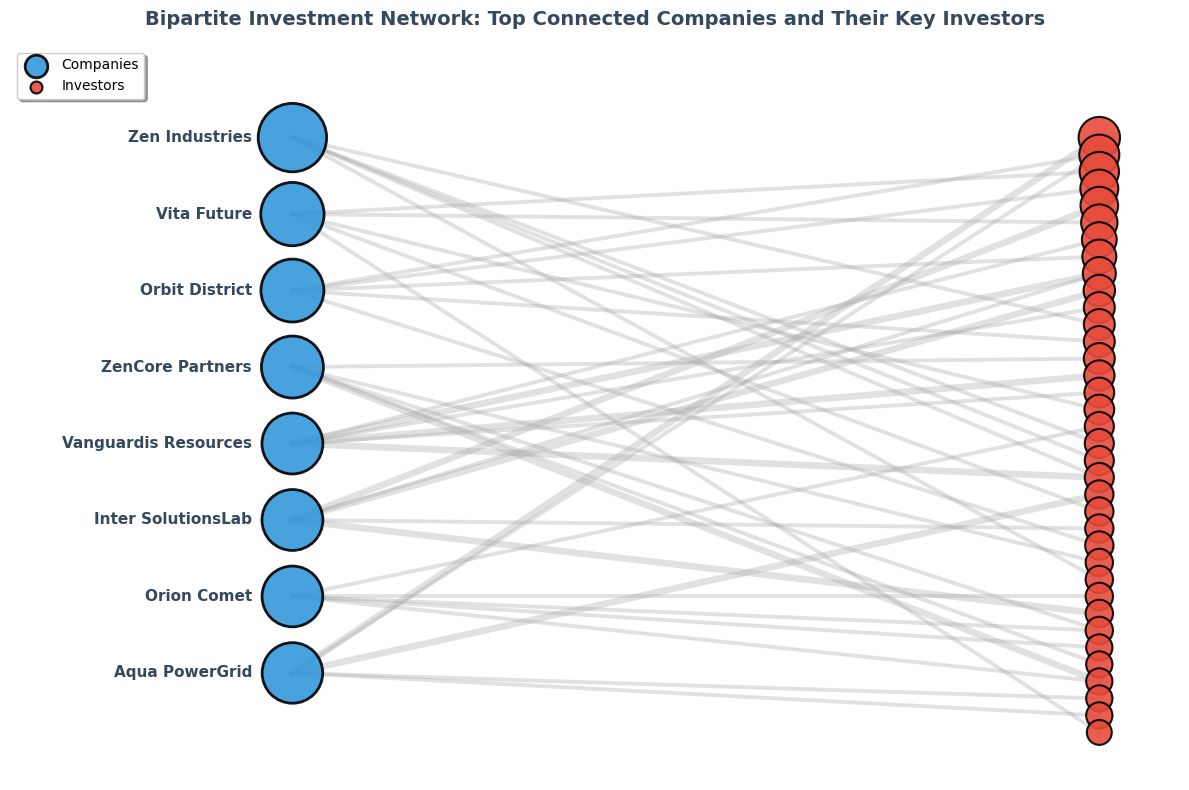

In [289]:
# Aesthetic config
COLORS = {'company': '#3498DB', 'investor': '#E74C3C', 'edge': '#AAAAAA', 'title': '#34495E'}
LOG_SCALES = {'company': 500, 'investor': 200}
LABEL_FONT = 11

# Select top companies & investors
top_companies = sorted([(n, B.degree(n)) for n in companies], key=lambda x: x[1], reverse=True)[:8]
selected_companies = {c for c, _ in top_companies}
selected_investors = set().union(*[set(sorted([n for n in B.neighbors(c)], 
                                              key=lambda x: B.degree(x), reverse=True)[:5]) 
                                   for c, _ in top_companies])

# Create positions
pos = {**{c: (0, 1 - i/len(top_companies)) for i, (c, _) in enumerate(top_companies)},
       **{i: (1, 1 - j/len(selected_investors)) 
          for j, i in enumerate(sorted(selected_investors, key=B.degree, reverse=True))}}

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Edges
edges = [(u, v, B[u][v]['weight']) for u, v in B.edges() 
         if u in selected_companies and v in selected_investors]
max_w = max([w for _, _, w in edges]) if edges else 1
[ax.plot([pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]], color=COLORS['edge'], 
         linewidth=0.8 + w/max_w*4, alpha=0.35, zorder=1) for u, v, w in edges]

# Company nodes
c_degrees = np.array([B.degree(c) for c, _ in top_companies])
ax.scatter([pos[c][0] for c, _ in top_companies], [pos[c][1] for c, _ in top_companies],
          s=np.log1p(c_degrees)*LOG_SCALES['company'], c=COLORS['company'], alpha=0.9,
          edgecolors='black', linewidth=2, label='Companies', zorder=3)

# Investor nodes
sorted_inv = sorted(selected_investors, key=B.degree, reverse=True)
i_degrees = np.array([B.degree(i) for i in sorted_inv])
ax.scatter([pos[i][0] for i in sorted_inv], [pos[i][1] for i in sorted_inv],
          s=np.log1p(i_degrees)*LOG_SCALES['investor'], c=COLORS['investor'], alpha=0.9,
          edgecolors='black', linewidth=1.5, label='Investors', zorder=3)

# Labels & finalize
[ax.text(pos[c][0]-0.05, pos[c][1], c, ha='right', va='center', fontsize=LABEL_FONT,
         fontweight='bold', color=COLORS['title'], zorder=4) for c, _ in top_companies]

ax.set(xlim=(-0.35, 1.1), ylim=(-0.05, 1.15))
ax.axis('off')
ax.set_title('Bipartite Investment Network: Top Connected Companies and Their Key Investors',
             fontsize=14, fontweight='bold', color=COLORS['title'], pad=15)
ax.legend(fontsize=10, loc='upper left', frameon=True, fancybox=True, shadow=True, markerscale=0.35)

plt.tight_layout()
plt.savefig('bipartite_cleanest.png', dpi=300, bbox_inches='tight')
plt.show()

## Network Statistics

In [41]:
# Basic statistics
print("Network Statistics:")
print(f"Number of nodes: {B.number_of_nodes()}")
print(f"Number of edges: {B.number_of_edges()}")
print(f"Density: {nx.density(B):.6f}")
print(f"\nConnected components: {nx.number_connected_components(B)}")

Network Statistics:
Number of nodes: 45367
Number of edges: 57395
Density: 0.000056

Connected components: 3132


In [42]:
# Degree statistics
company_degrees = [B.degree(n) for n in companies]
investor_degrees = [B.degree(n) for n in investors]

print("\nCompany degree statistics (number of investors):")
print(f"Mean: {np.mean(company_degrees):.2f}")
print(f"Median: {np.median(company_degrees):.2f}")
print(f"Max: {np.max(company_degrees)}")
print(f"Min: {np.min(company_degrees)}")

print("\nInvestor degree statistics (number of companies invested in):")
print(f"Mean: {np.mean(investor_degrees):.2f}")
print(f"Median: {np.median(investor_degrees):.2f}")
print(f"Max: {np.max(investor_degrees)}")
print(f"Min: {np.min(investor_degrees)}")


Company degree statistics (number of investors):
Mean: 4.22
Median: 3.00
Max: 128
Min: 1

Investor degree statistics (number of companies invested in):
Mean: 1.81
Median: 1.00
Max: 245
Min: 1


In [43]:
# Top companies by number of investors
top_companies = sorted([(n, B.degree(n)) for n in companies], key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 companies by number of investors:")
for company, degree in top_companies:
    print(f"{company}: {degree} investors")


Top 10 companies by number of investors:
Zen Industries: 128 investors
Vita Future: 63 investors
Orbit District: 60 investors
ZenCore Partners: 53 investors
Vanguardis Resources: 46 investors
Inter SolutionsLab: 46 investors
Orion Comet: 45 investors
Aqua PowerGrid: 44 investors
Turbo Storm: 43 investors
Golden FlowTech: 43 investors


In [44]:
# Top investors by number of companies
top_investors = sorted([(n, B.degree(n)) for n in investors], key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 investors by number of companies:")
for investor, degree in top_investors:
    print(f"{investor}: {degree} companies")


Top 10 investors by number of companies:
Patrick Brooks: 245 companies
Ronald Papadakis: 206 companies
Gabriel Henderson: 185 companies
Kent Dragomir: 155 companies
Tristan Weber: 114 companies
Spencer Perry: 106 companies
Robertson Reed: 104 companies
Jeffrey Ward: 92 companies
Scott Walton: 87 companies
Dylan Galanis: 85 companies


## Visualize Sample Subgraph

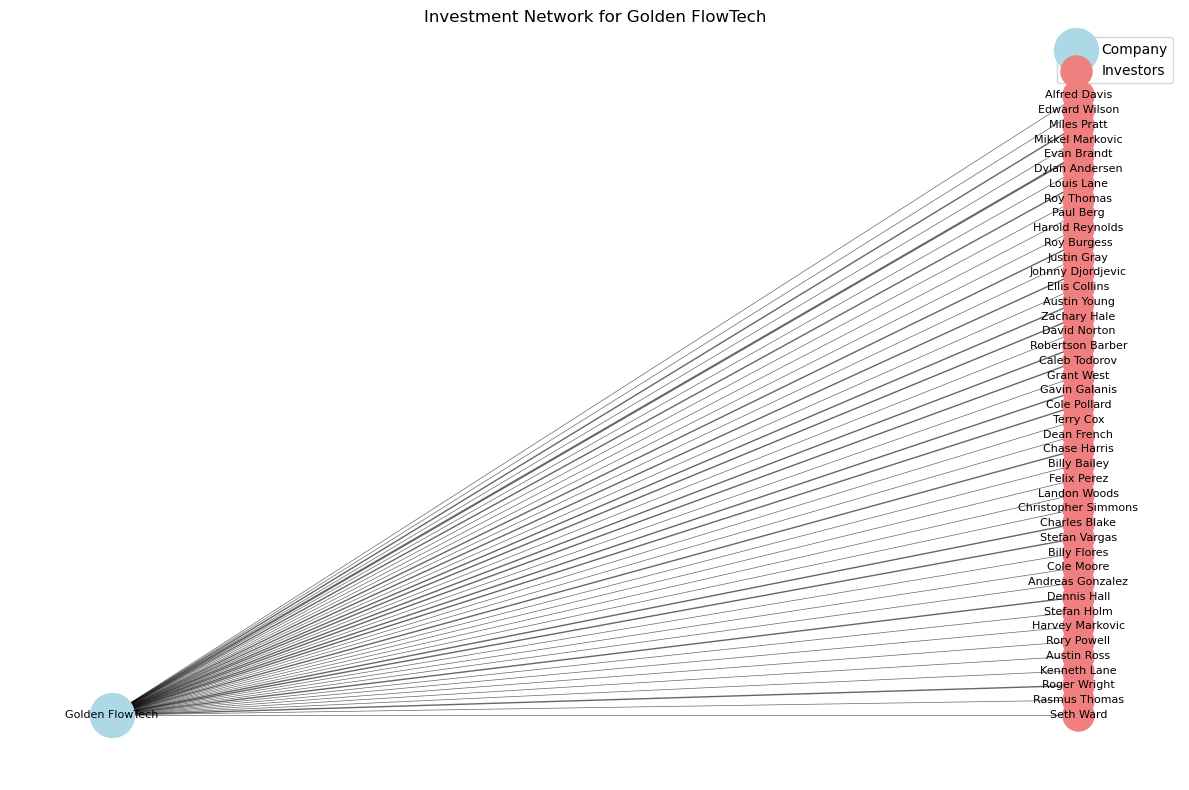

In [45]:
# Visualize a small subgraph (top company and its investors)
if top_companies:
    # choose 10th company
    top_company = top_companies[9][0]
    
    # Get neighbors (investors) of top company
    neighbors = list(B.neighbors(top_company))
    
    # Create subgraph
    subgraph_nodes = [top_company] + neighbors
    subgraph = B.subgraph(subgraph_nodes)
    
    # Create layout
    pos = nx.bipartite_layout(subgraph, [top_company])
    
    # Draw
    plt.figure(figsize=(12, 8))
    
    # Draw company node
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[top_company], 
                          node_color='lightblue', node_size=1000, label='Company')
    
    # Draw investor nodes
    nx.draw_networkx_nodes(subgraph, pos, nodelist=neighbors,
                          node_color='lightcoral', node_size=500, label='Investors')
    
    # Draw edges with weights
    edges = subgraph.edges()
    weights = [subgraph[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_edges(subgraph, pos, width=[w*0.5 for w in weights], alpha=0.6)
    
    # Draw labels
    nx.draw_networkx_labels(subgraph, pos, font_size=8)
    
    plt.title(f"Investment Network for {top_company}")
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## Save Network

In [46]:
# Save the network
# Convert None values to empty strings for GEXF compatibility
for node, data in B.nodes(data=True):
    for key, value in data.items():
        if value is None:
            B.nodes[node][key] = ""

nx.write_gexf(B, 'bipartite_network.gexf')
print("Network saved as 'bipartite_network.gexf'")

Network saved as 'bipartite_network.gexf'


## Access Node Attributes Example

In [47]:
# Example: Access attributes of a specific company
if top_companies:
    example_company = top_companies[0][0]
    print(f"Attributes for {example_company}:")
    for key, value in B.nodes[example_company].items():
        print(f"  {key}: {value}")

Attributes for Zen Industries:
  bipartite: 0
  node_type: company
  description: Developer of a decentralized blockchain infrastructure protocol designed for interoperability and scalability across multiple blockchain networks. The company's platform enables independent blockchains to exchange data and assets securely through a shared relay chain, supports custom blockchain development via modular frameworks, enabling developers to build and operate interconnected blockchain ecosystems with enhanced security, flexibility, and coordination.
  sector: Information Technology
  industry_group: Software
  industry_code: Software Development Applications


In [48]:
# Example: Access attributes of a specific investor
if top_investors:
    example_investor = top_investors[0][0]
    print(f"\nAttributes for {example_investor}:")
    for key, value in B.nodes[example_investor].items():
        print(f"  {key}: {value}")


Attributes for Patrick Brooks:
  bipartite: 1
  node_type: investor
  description: Founded in 2006, Patrick Brooks is an accelerator/incubator based in Sunnyvale, California. The firm prefers to invest in companies operating in advanced manufacturing, aerospace and defense, agricultural technology, animal health, brand and retail, cryptocurrency and digital assets, deep technology, energy, enterprise and artificial intelligence, financial technology, food and beverage, global overseas acceleration and learning, health, insurance technology, maritime, media and advertising, medical technology, mobility, new materials and packaging, real estate and construction, semiconductors, smart cities, sports technology, supply chain and logistics, sustainability, and travel and hospitality sectors. The firm also makes venture capital investments.
  lead_sole_count: 4
  investor_type: Accelerator/Incubator
  preferred_industry: Aerospace and Defense, Animal Husbandry, Aquaculture, Beverages, Commu

# Investor-Investor Network

Create a network where investors are connected based on co-investments.

- Two investors get connected if they both invested in the same company(s)
- Edge weight = number of companies they both invested in (co-investments)


## Create the network

In [49]:
# Create investor-investor network using bipartite projection

# Get investor nodes
investor_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}

# Create weighted projection
I = bipartite.weighted_projected_graph(B, investor_nodes)

print(f"Investor network: {I.number_of_nodes()} nodes, {I.number_of_edges()} edges")

Investor network: 31753 nodes, 231006 edges


In [50]:
# Normalize weights to [0, 1]
weights = [I[u][v]['weight'] for u, v in I.edges()]

if weights:
    min_w, max_w = min(weights), max(weights)
    print(f"Weight range: [{min_w}, {max_w}]")
    
    if max_w > min_w:
        for u, v in I.edges():
            I[u][v]['normalized_weight'] = (I[u][v]['weight'] - min_w) / (max_w - min_w)
    else:
        for u, v in I.edges():
            I[u][v]['normalized_weight'] = 1.0
    
    norm_weights = [I[u][v]['normalized_weight'] for u, v in I.edges()]
    print(f"Normalized: [{min(norm_weights):.3f}, {max(norm_weights):.3f}]")

Weight range: [1, 22]
Normalized: [0.000, 1.000]


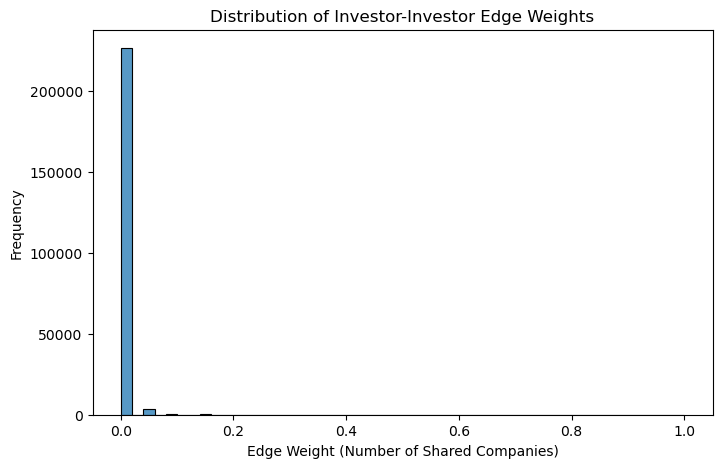

In [52]:
# plot weights distribution
plt.figure(figsize=(8, 5))
sns.histplot(norm_weights, bins=50)
plt.title("Distribution of Investor-Investor Edge Weights")
plt.xlabel("Edge Weight (Number of Shared Companies)")
plt.ylabel("Frequency")
plt.show()

### Add additional node attributes to the investors

We count the number of different industry groups the investor has invested in. This will be used in the final composite score. 

In [54]:
def update_investor_network_with_membership(B, I):
    """
    Calculates the number of unique Primary Industry Groups each investor has 
    invested in, using the bipartite graph B.
    """
    
    investor_nodes = {n for n, d in B.nodes(data=True) if d.get('bipartite') == 1}
    
    investor_groups = defaultdict(set)
    
    for investor in tqdm(investor_nodes, desc="Processing investors and groups"):
        for company in B.neighbors(investor):
            try:
                industry_group = B.nodes[company]['industry_group']
                investor_groups[investor].add(industry_group)
            except KeyError:
                continue

    investor_group_membership_counts = {
        investor: len(groups) for investor, groups in investor_groups.items()
    }

    group_count_attributes = {}
    
    for investor_node in I.nodes():
        count = investor_group_membership_counts.get(investor_node, 0)
        group_count_attributes[investor_node] = count
    
    nx.set_node_attributes(I, group_count_attributes, name='group_count')
    print(f"Group count attributes added to graph I as 'group_count'.")

In [55]:
update_investor_network_with_membership(B, I)

Processing investors and groups: 100%|██████████| 31753/31753 [00:00<00:00, 580780.74it/s]

Group count attributes added to graph I as 'group_count'.


We add as a node attribute how many times the investor has been a sole/lead investor. This data is found in the original dataset. 

In [56]:
# normalize lead counts to [0, 1]

def normalize_lead_counts(I_network, raw_attribute_name='lead_sole_count', normalized_attribute_name='lead_score_normalized'):
    """
    Calculates the normalized lead score for all investors in the network I.
    """
    
    # 1. Gather all raw lead counts
    raw_counts = [data.get(raw_attribute_name, 0) for node, data in I_network.nodes(data=True)]
    
    if not raw_counts:
        print("Warning: No investors found or raw lead attribute missing.")
        return

    min_count = min(raw_counts)
    max_count = max(raw_counts)

    if max_count == min_count:
        # Avoid division by zero if all counts are the same
        normalized_values = {node: 0.0 for node in I_network.nodes()}
    else:
        normalized_values = {}
        # 2. Normalize each count to the [0, 1] range
        for node, data in I_network.nodes(data=True):
            raw_count = data.get(raw_attribute_name, 0)
            normalized_score = (raw_count - min_count) / (max_count - min_count)
            normalized_values[node] = normalized_score
            
    # 3. Add the new normalized score as a node attribute
    nx.set_node_attributes(I_network, normalized_values, name=normalized_attribute_name)
    print(f"Normalized lead scores added to graph I as '{normalized_attribute_name}'.")

# You must call this function during your data setup, e.g.:
normalize_lead_counts(I, raw_attribute_name='lead_sole_count')

Normalized lead scores added to graph I as 'lead_score_normalized'.


Here we create a dictionary to store industry investments for each investor. This will be used later to create communities based on industry groups. 

In [57]:
# Create a dictionary to store industry investments for each investor
investor_industries = defaultdict(lambda: defaultdict(int))

# Filter out rows with missing data
valid_data = df.dropna(subset=['Primary Industry Group_deal', 'Investors'])

# Process the data using vectorized operations
for industry, investor in zip(valid_data['Primary Industry Group_deal'], valid_data['Investors']):
    investor_industries[investor][industry] += 1

# Convert defaultdict to regular dict for each investor
for investor in investor_industries:
    investor_industries[investor] = dict(investor_industries[investor])

# Add the industry_investments attribute to investor nodes
for node in I.nodes():
    if node in investor_industries:
        I.nodes[node]['industry_investments'] = investor_industries[node]
    else:
        I.nodes[node]['industry_investments'] = {}

In [59]:
# see attribute example
example_investor = list(I.nodes())[19]
print(f"Investor: {example_investor}")
print(f"Group Count: {I.nodes[example_investor].get('group_count', 'N/A')}")
print(f"Lead Count: {I.nodes[example_investor].get('lead_sole_count', 'N/A')}")
print(f"Normalized Lead Score: {I.nodes[example_investor].get('lead_score_normalized', 'N/A')}")
print(f"Industry Investments: {I.nodes[example_investor].get('industry_investments', 'N/A')}")

Investor: Harold Simmons
Group Count: 1
Lead Count: 0
Normalized Lead Score: 0.0
Industry Investments: {'Commercial Services': 1}


#### Degree distribution of both bipartite network and investor network

Companies per investor — mean: 1.81, median: 1, max: 245
Investor-network degree — mean: 14.55, median: 8, max: 1483


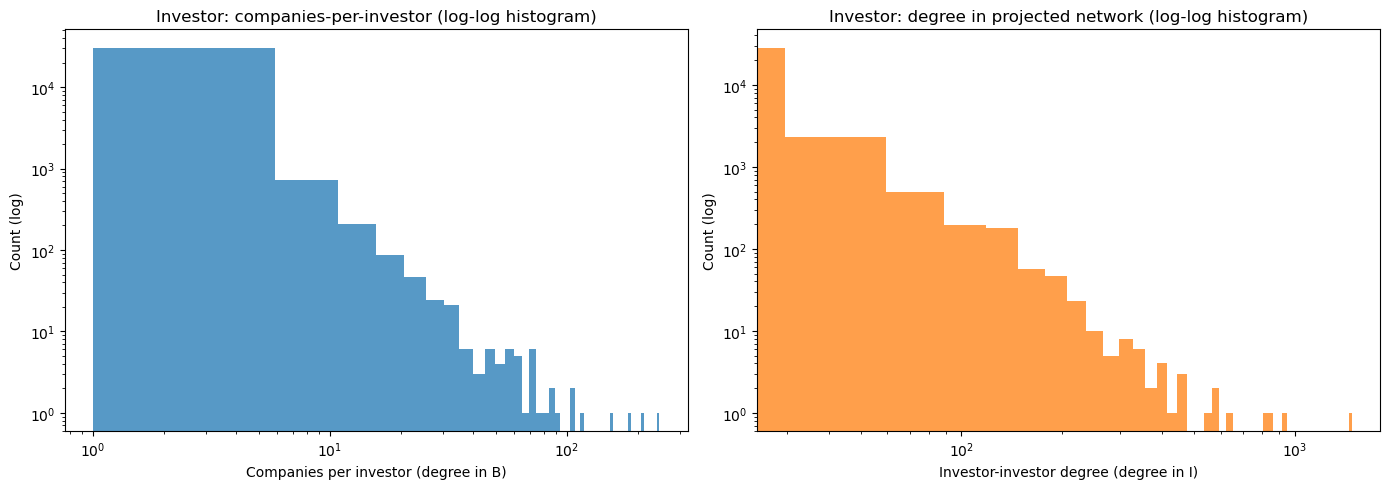

In [103]:
# degrees: companies per investor (degree in bipartite B)
investor_nodes_bip = [n for n, d in B.nodes(data=True) if d.get('bipartite') == 1]
degrees_companies = np.array([B.degree(n) for n in investor_nodes_bip])

# degrees: investor-investor (degree in projected graph I)
degrees_investor_net = np.array([I.degree(n) for n in I.nodes()])

print(f"Companies per investor — mean: {degrees_companies.mean():.2f}, median: {np.median(degrees_companies):.0f}, max: {degrees_companies.max()}")
print(f"Investor-network degree — mean: {degrees_investor_net.mean():.2f}, median: {np.median(degrees_investor_net):.0f}, max: {degrees_investor_net.max()}")

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.histplot(degrees_companies, bins=50, color='C0', edgecolor=None)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Companies per investor (degree in B)')
plt.ylabel('Count (log)')
plt.title('Investor: companies-per-investor (log-log histogram)')

plt.subplot(1,2,2)
sns.histplot(degrees_investor_net, bins=50, color='C1', edgecolor=None)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Investor-investor degree (degree in I)')
plt.ylabel('Count (log)')
plt.title('Investor: degree in projected network (log-log histogram)')

plt.tight_layout()
plt.show()

#### Compute centrality measures

Here we first started computing centrality measures for the whole network but then realized that in our case it made more sense to compute them for a subnetwork, so we do this later in our pipeline. 

In [104]:
# betweenness_scores = nx.betweenness_centrality(I, weight='weight', normalized=True)

In [105]:
#degree_scores = nx.degree_centrality(I)

In [106]:
# num_nodes = I.number_of_nodes()
# k_samples = max(100, min(int(0.1 * num_nodes), 1000))
# nodes_list = list(I.nodes())
# nodes_to_sample = random.sample(nodes_list, k_samples)

# approx_betweenness_scores = nx.betweenness_centrality_subset(
#     I, 
#     sources=nodes_to_sample,  # Pass the native Python list as sources
#     targets=I.nodes(),        # Use all nodes as targets
#     weight='weight',          # Use the edge weight for path calculation
#     normalized=True           # Normalize the scores between 0 and 1
# )

In [107]:
# # using Betweenness
# #investor_centrality_scores = approx_betweenness_scores 

# # using Degree
# investor_centrality_scores = degree_scores
# # 
# print(f"Sample Top 5 Investors by Centrality:")
# top_investors = sorted(investor_centrality_scores.items(), key=lambda item: item[1], reverse=True)[:5]
# for inv, score in top_investors:
#     print(f"  {inv}: {score:.4f}")

In [60]:
# Save investor network
for node, data in I.nodes(data=True):
    for key, value in data.items():
        if value is None:
            I.nodes[node][key] = ""

nx.write_gexf(I, 'investor_network.gexf')
print("Saved as 'investor_network.gexf'")

Saved as 'investor_network.gexf'


## Visualize the network

In [61]:
I = nx.read_gexf('investor_network.gexf')

In [62]:
I.number_of_nodes()

31753

Visualization of a subnetwork of investors

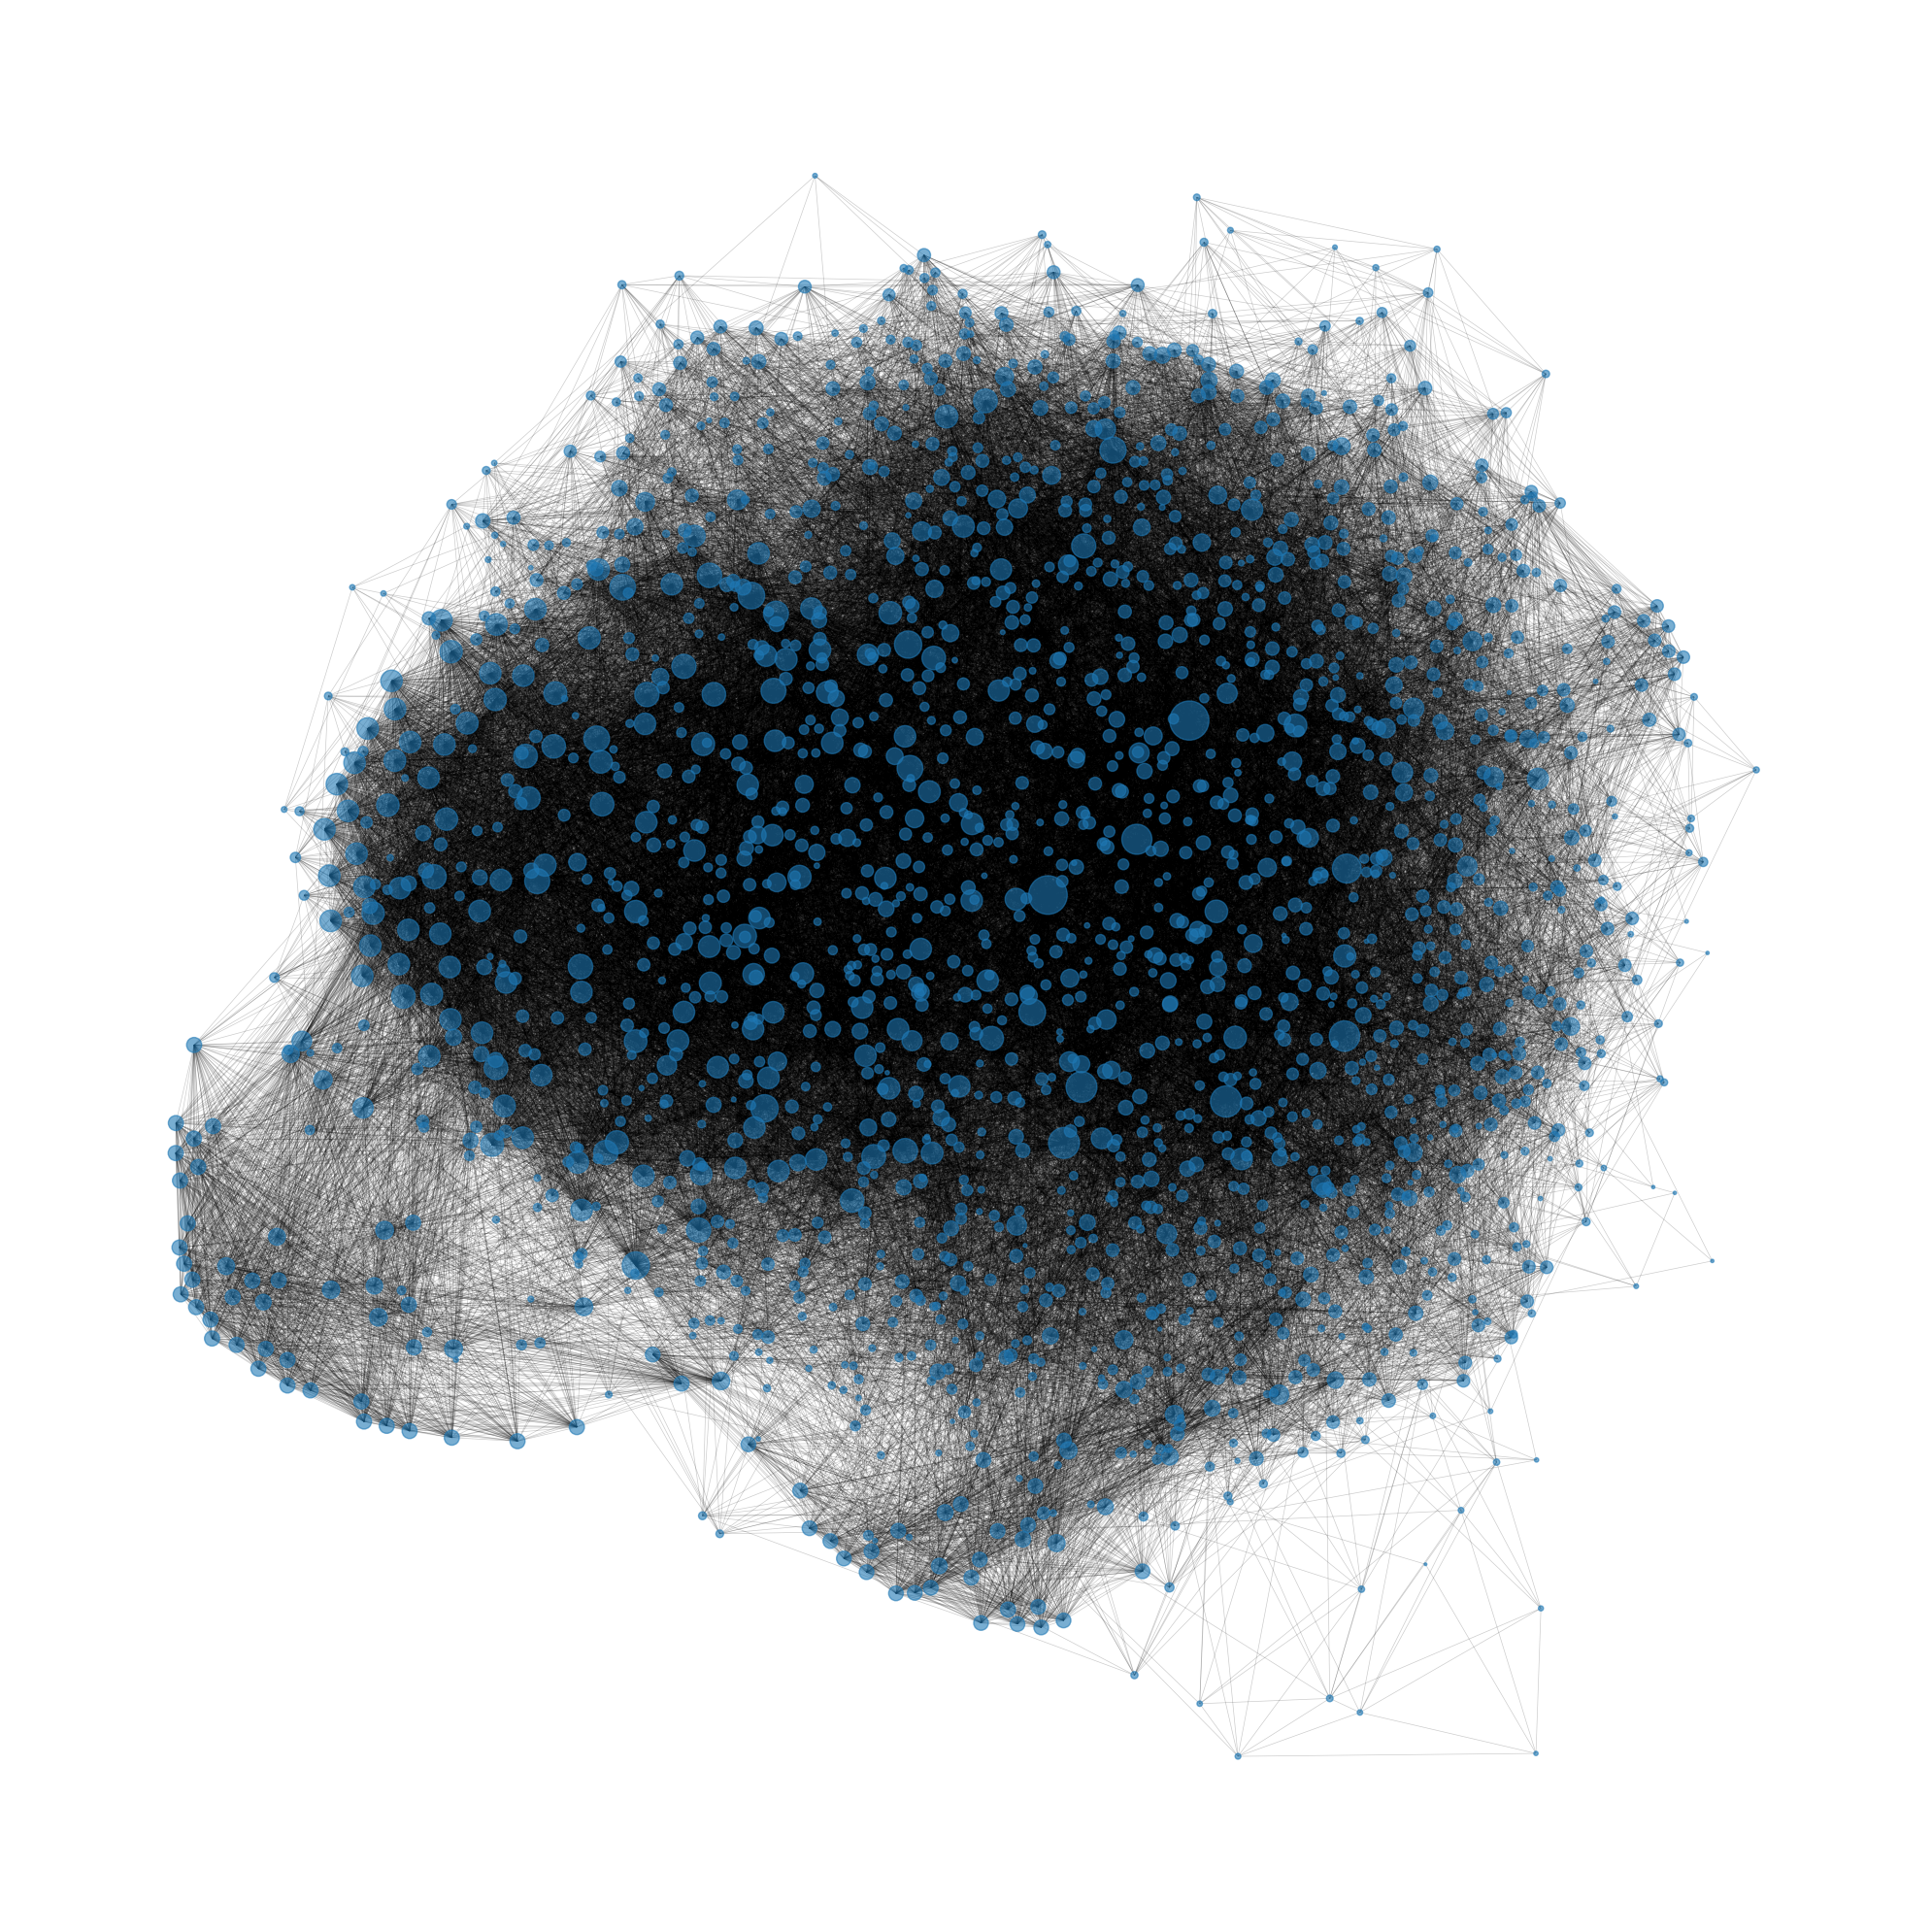

In [63]:
# Top degree nodes
top_n = 2000
top_nodes = sorted(I.degree(), key=lambda x: x[1], reverse=True)[:top_n]
top_node_names = [node for node, degree in top_nodes]
subgraph = I.subgraph(top_node_names)

# Plot figure
plt.figure(figsize=(20, 20))

# Fast layouts for large graphs:
pos = nx.forceatlas2_layout(subgraph)  # Good quality, slower
# pos = nx.spring_layout(subgraph, k=1, iterations=20)  # Faster

# Calculate node sizes based on degree
node_degrees = dict(subgraph.degree())
node_sizes = [node_degrees[node] * 2 for node in subgraph.nodes()]  # Scale factor of 2

# Draw without labels for speed
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, alpha=0.6)
nx.draw_networkx_edges(subgraph, pos, alpha=0.2, width=0.5)
plt.axis('off')
plt.tight_layout()
plt.savefig('network.png', dpi=150, bbox_inches='tight')


## Community detection

### Communities extracted from Louvain algorithm

This function is used to compute the modularity for the communities

In [71]:
def modularity_from_communities(G_in, communities):
    m_edges = G_in.number_of_edges()
    if m_edges == 0:
        return 0.0
    Q = 0.0
    for C in communities:
        L_c = G_in.subgraph(C).number_of_edges()             # internal edges
        D_c = sum(dict(G_in.degree(C)).values())             # sum of degrees (in G_in)
        Q += (L_c / m_edges) - (D_c / (2 * m_edges)) ** 2
    return Q


Compute Louvain communities using the Louvain Algorithm

Louvain modularity: 0.7189
Layout: ForceAtlas2 (fa2) used.


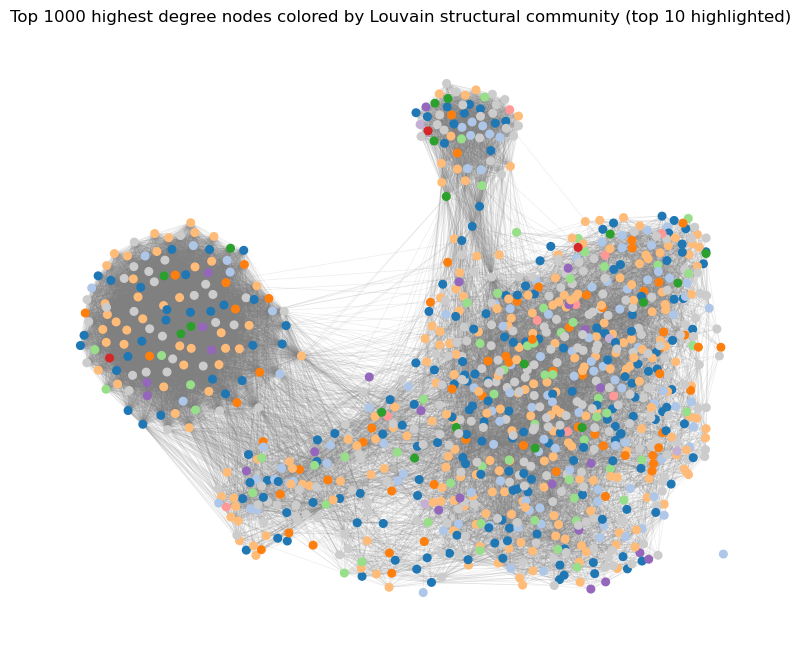

Number of Louvain communities: 3204
Sizes of top communities: [3455, 3045, 2189, 1501, 998, 974, 929, 801, 792, 747, 664, 637, 625, 592, 544, 479, 437, 421, 417, 416, 405, 396, 386, 363, 362, 347, 343, 320, 307, 307, 304, 293, 270, 258, 183, 182, 69, 64, 54, 38, 34, 27, 25, 23, 22, 22, 21, 21, 20, 19, 17, 17, 15, 14, 14, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

In [72]:
# 1) compute Louvain communities (try networkx implementation, fallback to python-louvain)
try:
    louvain_comms = louvain_communities(I, resolution=1, seed=42) # lower resolution creates larger communities
except Exception as e:
    raise RuntimeError("Louvain community detection not available: " + str(e))

# 2) modularity of Louvain partition (using provided helper)
Q_louvain = modularity_from_communities(I, louvain_comms)
print(f"Louvain modularity: {Q_louvain:.4f}")

# 3) prepare coloring for visualization: color top K largest communities, rest gray
comm_sizes = sorted([(i, len(c)) for i, c in enumerate(louvain_comms)], key=lambda x: -x[1])
top_k = 10
top_comm_idxs = [i for i, _ in comm_sizes[:top_k]]

node_to_comm = {}
for idx, comm in enumerate(louvain_comms):
    for n in comm:
        node_to_comm[n] = idx

# map nodes to colors
cmap = plt.get_cmap("tab20")
colors = {}
for i, comm_idx in enumerate(top_comm_idxs):
    colors[comm_idx] = cmap(i % 20)
# default color for small communities
default_color = (0.8, 0.8, 0.8)

# 4) select top 1000 nodes by degree
degrees = dict(I.degree())
top_1000_nodes = sorted(degrees.keys(), key=lambda x: degrees[x], reverse=True)[:1000]
top_1000_subgraph = I.subgraph(top_1000_nodes)
node_colors = [colors.get(node_to_comm.get(n, None), default_color) for n in top_1000_nodes]

# 5) compute layout: use forceatlas2_layout imported from networkx if available, else spring_layout
pos = None
try:
    pos = forceatlas2_layout(
                                top_1000_subgraph,
                                pos=None, 
                                max_iter=2000, 
                                gravity=0.3, 
                                strong_gravity=True, 
                                jitter_tolerance=0.5,
                                seed=42
    )
    print("Layout: ForceAtlas2 (fa2) used.")
except Exception:
    pos = nx.spring_layout(top_1000_subgraph, seed=42, k=0.1, iterations=200)
    print("Layout: networkx spring_layout used (ForceAtlas2 unavailable).")

# 6) draw top 1000 nodes colored by community (highlighting top K communities)
plt.figure(figsize=(10, 8))
# draw edges faintly
nx.draw_networkx_edges(top_1000_subgraph, pos, alpha=0.15, edge_color="gray", width=0.5)
# draw nodes
nx.draw_networkx_nodes(top_1000_subgraph, pos,
                       node_color=node_colors,
                       node_size=30)
plt.axis('off')
plt.title(f"Top 1000 highest degree nodes colored by Louvain structural community (top {top_k} highlighted)")
plt.show()

# 9) short quantitative summary of communities
num_comms = len(louvain_comms)
sizes = sorted([len(c) for c in louvain_comms], reverse=True)
print(f"Number of Louvain communities: {num_comms}")
print(f"Sizes of top communities: {sizes}")


In [73]:
# measure how many communities have size 1
num_singleton_comms_1 = sum(1 for size in sizes if size == 1)
num_singleton_comms_2 = sum(1 for size in sizes if size == 2)
num_singleton_comms_3 = sum(1 for size in sizes if size == 3)
print(f"Number of singleton communities (size 1): {num_singleton_comms_1+num_singleton_comms_2+num_singleton_comms_3}")

Number of singleton communities (size 1): 2851


In [74]:
# percentage of investors in top 50 communities
top_50_sizes = sizes[:50]
percentage_top_50 = sum(top_50_sizes) / I.number_of_nodes() * 100
print(f"Percentage of investors in top 50 communities: {percentage_top_50:.2f}%")

Percentage of investors in top 50 communities: 82.35%


In [75]:
# node_to_comm: A dictionary mapping every investor ID to their Louvain community index/ID.+
list(node_to_comm.items())[:10]


[('Alan Bauer', 0),
 ('Clifford Karlsson', 1),
 ('Colin Dalton', 2),
 ('Arvid Garcia', 3),
 ('Randy Wood', 4),
 ('Tate Lund', 4),
 ('Reuben Taylor', 4),
 ('David Dragomir', 4),
 ('Clinton Todorov', 4),
 ('Corbin Neumann', 4)]

### Communities based on Industry 

In [76]:
# Create communities based on industries
industry_communities = {}

# Get all unique industries from all investors
all_industries = df['Primary Industry Group_deal'].dropna().unique()

# Create a community for each industry
for industry in all_industries:
    industry_communities[industry] = []
    for node in I.nodes():
        if 'industry_investments' in I.nodes[node]:
            if industry in I.nodes[node]['industry_investments']:
                industry_communities[industry].append(node)

# Print community information sorted by the number of investors
sorted_industries = sorted(industry_communities.items(), key=lambda x: len(x[1]), reverse=True)

for industry, members in sorted_industries[:5]:
    print(f"Industry: {industry}")
    print(f"Number of investors: {len(members)}")
    print(f"Members: {members[:10]}...")  # Show first 10 members
    print()

Industry: Software
Number of investors: 15490
Members: ['Alfred Kane', 'Johnny Roy', 'Ronald Lopez', 'Noah Phillips', 'Isaac Magnussen', 'Alan Bauer', 'Max Nelson', 'Diego Ramirez', 'Frederik Bailey', 'Colin Dalton']...

Industry: Commercial Services
Number of investors: 4075
Members: ['Johnny Roy', 'Harold Simmons', 'Arvid Manning', 'Preston Christensen', 'Robert Fritz', 'Patrick Wood', 'Donald Djordjevic', 'Magnus Collins', 'Timothy Woods', 'Willie Lopez']...

Industry: Pharmaceuticals and Biotechnology
Number of investors: 2357
Members: ['Billy Flores', 'Kenneth Pedersen', 'Rodrigo Young', 'Hugo Evans', 'Viktor Hardy', 'Preston Christensen', 'Terrence Baker', 'Bobby Williams', 'Donald Djordjevic', 'Willie Lopez']...

Industry: Healthcare Devices and Supplies
Number of investors: 1942
Members: ['Kenneth Pedersen', 'Eric Bauer', 'Marek Gray', 'Preston Christensen', 'James Madsen', 'Samuel Bolton', 'Christian Karlsson', 'Terrence Baker', 'Bobby Williams', 'Noah Lopez']...

Industry: Co

In [77]:
# Calculate modularity of the communities
modularity = modularity_from_communities(I, industry_communities.values())
print(f"Modularity: {modularity:.4f}")


Modularity: 0.5827


Top 7 industries:
  1. Software: 15490 investors
  2. Commercial Services: 4075 investors
  3. Pharmaceuticals and Biotechnology: 2357 investors
  4. Healthcare Devices and Supplies: 1942 investors
  5. Computer Hardware: 1931 investors
  6. Commercial Products: 1870 investors
  7. Healthcare Technology Systems: 1869 investors
  8. Other Financial Services: 1762 investors
  9. Consumer Non-Durables: 1696 investors
  10. Services (Non-Financial): 1305 investors

Top 7 Louvain communities:
  1. Louvain Community 890: 3455 investors
  2. Louvain Community 3034: 3045 investors
  3. Louvain Community 64: 2189 investors
  4. Louvain Community 2428: 1501 investors
  5. Louvain Community 3088: 998 investors
  6. Louvain Community 587: 974 investors
  7. Louvain Community 2634: 929 investors
  8. Louvain Community 420: 801 investors
  9. Louvain Community 108: 792 investors
  10. Louvain Community 122: 747 investors

Confusion Matrix D (10 industries × 10 Louvain communities):
Rows = Industries

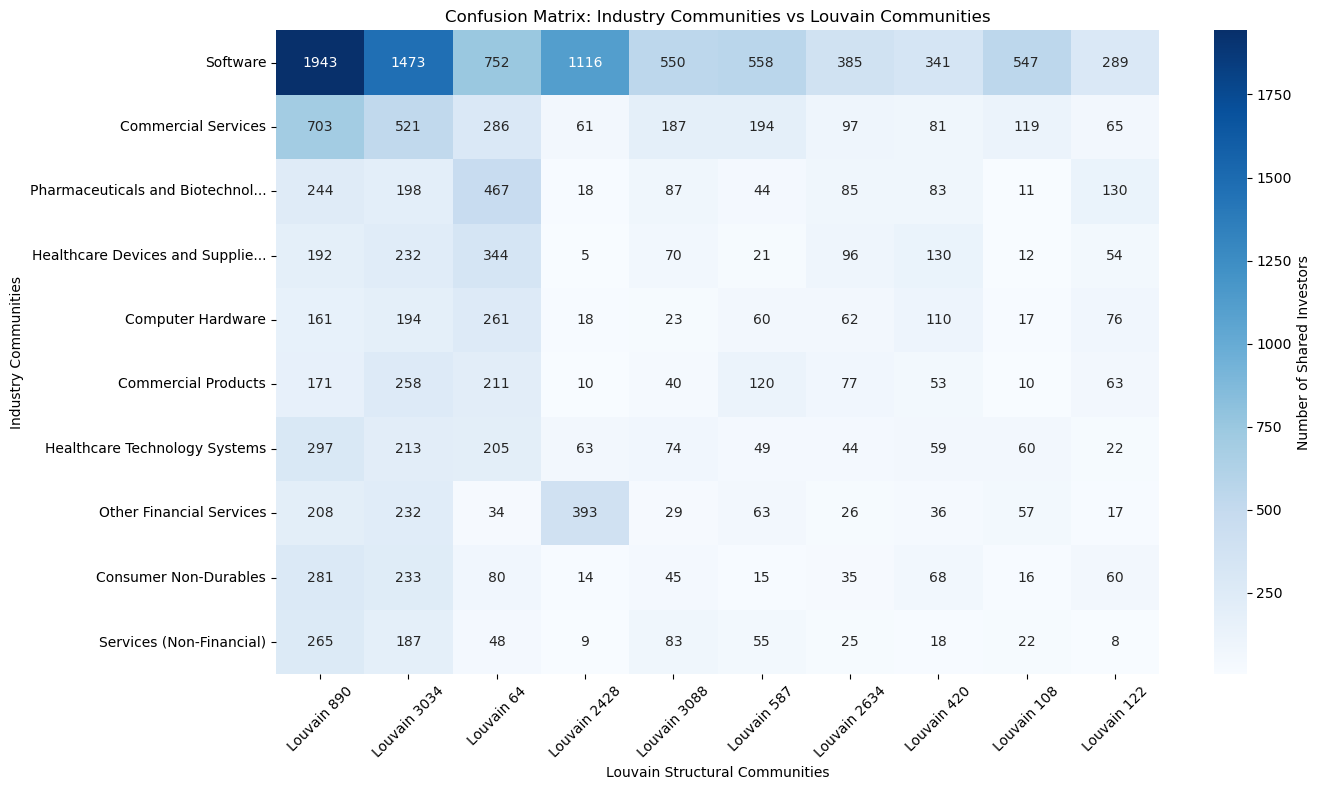


Additional Analysis:


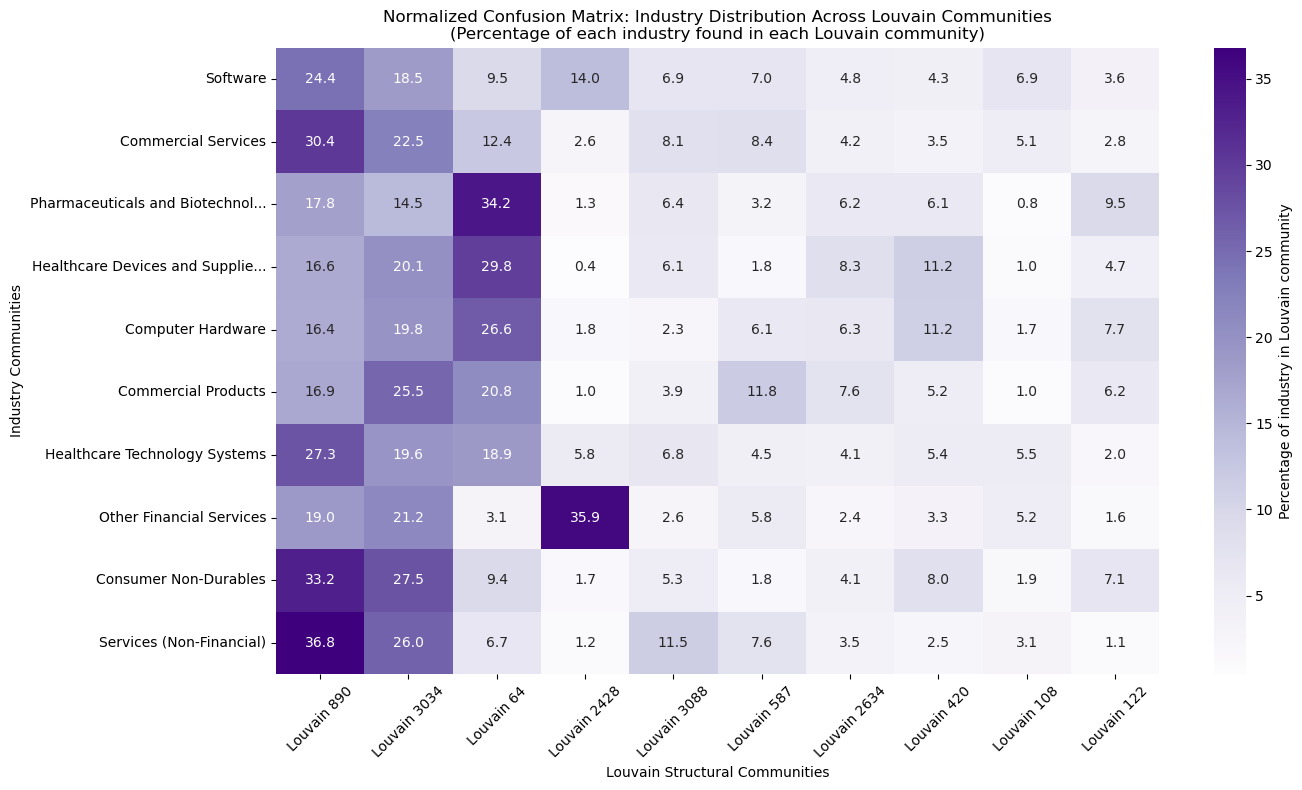

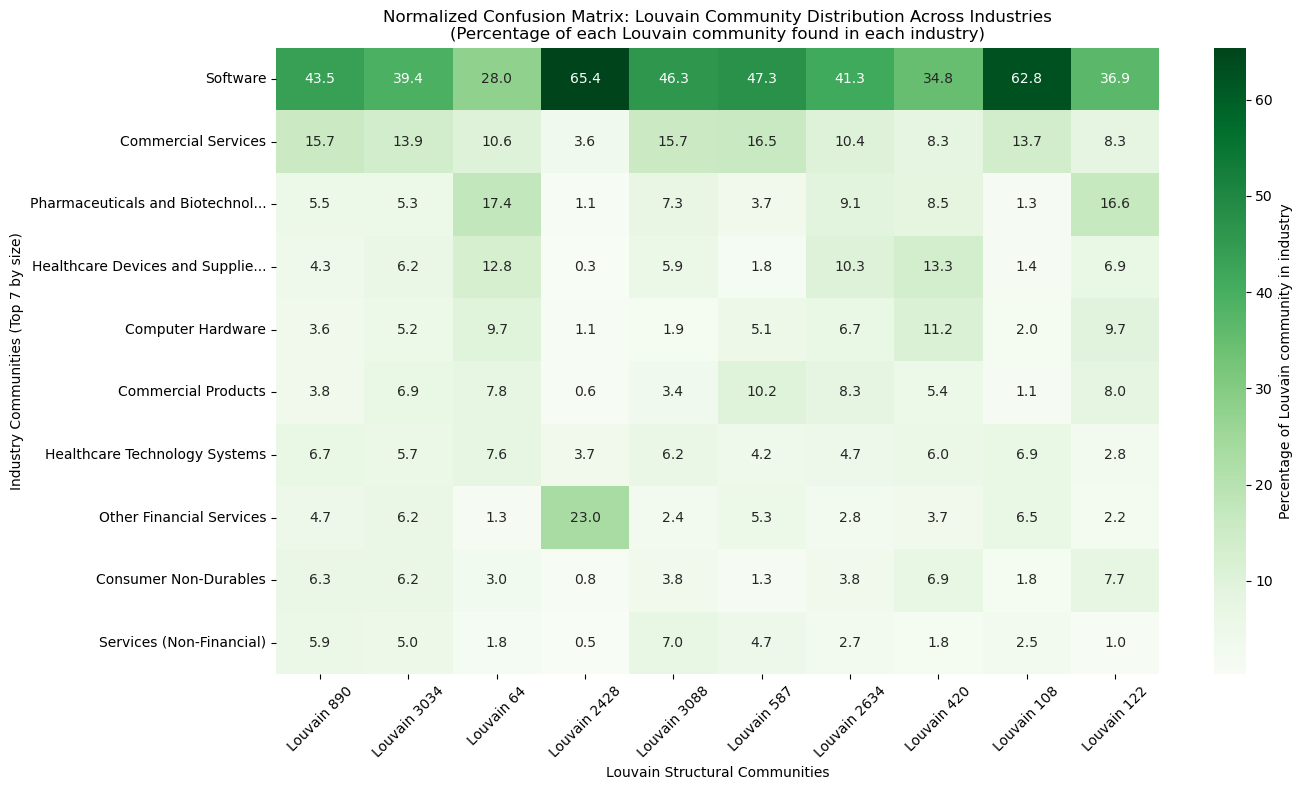

In [82]:
def create_industry_confusion_matrix(I, louvain_communities, industry_communities):
    """
    Create a confusion matrix comparing Louvain communities with industry-based communities.
    
    Args:
        I: NetworkX graph (investor network)
        louvain_communities: List of community sets from Louvain algorithm
        industry_communities: Dict of {industry: [list_of_investors]} from industry grouping
        
    Returns:
        tuple: (confusion_matrix, top_industries, top_louvain_communities, industry_to_idx, louvain_to_idx)
    """
    
    # Create mapping from node to Louvain community ID
    node_to_louvain = {}
    for i, community in enumerate(louvain_communities):
        for node in community:
            node_to_louvain[node] = i
    
    # Get Louvain community sizes and find top 7 largest communities
    louvain_sizes = [(i, len(community)) for i, community in enumerate(louvain_communities)]
    louvain_sizes.sort(key=lambda x: x[1], reverse=True)
    top_7_louvain = [comm_id for comm_id, size in louvain_sizes[:10]]
    
    # Get industry community sizes and find top 7 largest industries
    industry_sizes = [(industry, len(members)) for industry, members in industry_communities.items()]
    industry_sizes.sort(key=lambda x: x[1], reverse=True)
    top_7_industries = [industry for industry, size in industry_sizes[:10]]
    
    print("Top 7 industries:")
    for i, (industry, count) in enumerate(industry_sizes[:10]):
        print(f"  {i+1}. {industry}: {count} investors")
    
    print(f"\nTop 7 Louvain communities:")
    for i, (comm_id, size) in enumerate(louvain_sizes[:10]):
        print(f"  {i+1}. Louvain Community {comm_id}: {size} investors")
    
    # Create confusion matrix D (7 industries × 7 Louvain communities)
    D = np.zeros((10, 10), dtype=int)
    
    # Create mappings for matrix indices
    industry_to_idx = {industry: i for i, industry in enumerate(top_7_industries)}
    louvain_to_idx = {comm_id: i for i, comm_id in enumerate(top_7_louvain)}
    
    # Fill the confusion matrix
    for node in I.nodes():
        # Check if node is in one of the top 7 Louvain communities
        if node in node_to_louvain and node_to_louvain[node] in top_7_louvain:
            louvain_idx = louvain_to_idx[node_to_louvain[node]]
            
            # Check which industries this investor belongs to
            for industry in top_7_industries:
                if industry in industry_communities and node in industry_communities[industry]:
                    industry_idx = industry_to_idx[industry]
                    D[industry_idx, louvain_idx] += 1

    return D, top_7_industries, top_7_louvain, industry_to_idx, louvain_to_idx

# Create the confusion matrix
D, top_industries, top_louvain, industry_to_idx, louvain_to_idx = create_industry_confusion_matrix(
    I, louvain_comms, industry_communities
)

print(f"\nConfusion Matrix D ({len(top_industries)} industries × {len(top_louvain)} Louvain communities):")
print("Rows = Industries, Columns = Louvain Communities")
print(f"Matrix shape: {D.shape}")

# Create a pandas DataFrame for better visualization
df_confusion = pd.DataFrame(
    D, 
    index=[f"I{i}: {industry}" for i, industry in enumerate(top_industries)],
    columns=[f"L{i}: Comm{comm_id}" for i, comm_id in enumerate(top_louvain)]
)

# print("\nConfusion Matrix DataFrame:")
# print(df_confusion)
# Visualize the confusion matrix
plt.figure(figsize=(14, 8))
sns.heatmap(D, 
            xticklabels=[f"Louvain {comm_id}" for comm_id in top_louvain],
            yticklabels=[industry[:30] + '...' if len(industry) > 30 else industry for industry in top_industries],
            annot=True, 
            fmt='d', 
            cmap='Blues',
            cbar_kws={'label': 'Number of Shared Investors'})

plt.title('Confusion Matrix: Industry Communities vs Louvain Communities')
plt.xlabel('Louvain Structural Communities')
plt.ylabel('Industry Communities')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate row and column sums
row_sums = np.sum(D, axis=1)  # Total investors per industry (across all top Louvain communities)
col_sums = np.sum(D, axis=0)  # Total investors per Louvain community (across all top industries)

# Calculate normalized confusion matrix (percentages by row)
row_sums_safe = np.where(row_sums == 0, 1, row_sums)
D_normalized_by_row = D / row_sums_safe[:, np.newaxis] * 100


print(f"\nAdditional Analysis:")
# Visualize normalized matrix
plt.figure(figsize=(14, 8))
sns.heatmap(D_normalized_by_row, 
            xticklabels=[f"Louvain {comm_id}" for comm_id in top_louvain],
            yticklabels=[industry[:30] + '...' if len(industry) > 30 else industry for industry in top_industries],
            annot=True, 
            fmt='.1f', 
            cmap='Purples',
            cbar_kws={'label': 'Percentage of industry in Louvain community'})

plt.title('Normalized Confusion Matrix: Industry Distribution Across Louvain Communities\n(Percentage of each industry found in each Louvain community)')
plt.xlabel('Louvain Structural Communities')
plt.ylabel('Industry Communities')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Calculate normalized confusion matrix (percentages by column)
col_sums_safe = np.where(col_sums == 0, 1, col_sums)
D_normalized_by_col = D / col_sums_safe[np.newaxis, :] * 100

# Visualize normalized matrix by column
plt.figure(figsize=(14, 8))
sns.heatmap(D_normalized_by_col, 
            xticklabels=[f"Louvain {comm_id}" for comm_id in top_louvain],
            yticklabels=[industry[:30] + '...' if len(industry) > 30 else industry for industry in top_industries],
            annot=True, 
            fmt='.1f', 
            cmap='Greens',
            cbar_kws={'label': 'Percentage of Louvain community in industry'})

plt.title('Normalized Confusion Matrix: Louvain Community Distribution Across Industries\n(Percentage of each Louvain community found in each industry)')
plt.xlabel('Louvain Structural Communities')
plt.ylabel('Industry Communities (Top 7 by size)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## NLP for community focus

### Term Frequency lists for each investor

Here we create a description for each investor. Each description will consist of the columns "Description_deal", "Keywords_deal", "Primary Industry Sector_deal" and "Primary Industry Group_deal". 

In [83]:
# Extract company descriptions for investors
def create_investor_portfolio_descriptions(I, df):
    """Create portfolio descriptions for each investor based on companies they invest in"""
    investor_portfolios = {}

    for investor in tqdm(I.nodes(), desc="Creating investor portfolios"):
        # Get all companies this investor has invested in
        investor_rows = df[df['Investors'] == investor]

        # Collect different text components
        descriptions = investor_rows['Description_deal'].dropna().tolist()
        keywords = investor_rows['Keywords_deal'].dropna().tolist() if 'Keywords_deal' in df.columns else []
        sectors = investor_rows['Primary Industry Sector_deal'].dropna().tolist()
        groups = investor_rows['Primary Industry Group_deal'].dropna().tolist()
        
        # Combine all text components
        all_text_components = []
        
        # Add descriptions
        if descriptions:
            all_text_components.extend(descriptions)
        
        # Add keywords (if available)
        if keywords:
            all_text_components.extend(keywords)
        
        # Add sectors
        if sectors:
            all_text_components.extend(sectors)
        
        # Add industry groups
        if groups:
            all_text_components.extend(groups)
        
        # Combine all components into one portfolio description
        investor_portfolios[investor] = ' '.join(all_text_components)
    
    return investor_portfolios

# Create portfolio descriptions
investor_portfolios = create_investor_portfolio_descriptions(I, df)

# Remove empty portfolios
investor_portfolios = {k: v for k, v in investor_portfolios.items() if v.strip()}

print(f"Created portfolio descriptions for {len(investor_portfolios)} investors")


Creating investor portfolios: 100%|██████████| 31753/31753 [00:50<00:00, 628.06it/s]

Created portfolio descriptions for 31753 investors


Now, we process these descriptions. We first convert the text to lowercase, we remove punctuation signs and tokenize it. Then, we remove the stopwords, the common ones, defined in nltk.corpus.stopwords.words('english'), and also the custom ones, which are the ones that appear in almost all texts and do not give meaningful information to characterize an industry. We also filter out words with less than 3 characters. Then, we define the uni- and bigrams, so we will be using single and pairs of words. After this, we filter out less common words, so if a word is appears less than 3 times in the whole text, it is filtered. Finally, we create a Term Frequency list for each investor. 

In [84]:
stop_words = set(stopwords.words('english'))

custom_stop_words = set(['platform', 'technology', 'healthcare', 'enabling', 
                         'developer', 'software', 'data', 'services', 
                         'designed', 'management', 'information', 'products', 
                         'information_technology', 'system', 'intended', 'offers', 
                         'energy'])

all_stop_words = stop_words.union(custom_stop_words)

def generate_ngrams(tokens, n=2):
    """Generates unigrams and bigrams from a list of tokens."""
    unigrams = tokens
    
    # Generate bigrams (pairs)
    bigrams = ['_'.join(tokens[i:i+2]) for i in range(len(tokens) - 1)]
    
    # trigrams = ['_'.join(tokens[i:i+3]) for i in range(len(tokens) - 2)]
    
    return unigrams + bigrams


def preprocess_portfolio_descriptions_to_tf(investor_portfolios, min_frequency=3):
    """
    Preprocess portfolio descriptions and create Term Frequency lists.
    
    Args:
        investor_portfolios: Dict of {investor: portfolio_description}
        min_frequency: Minimum word frequency to keep (default=3)
        
    Returns:
        investor_tf_lists: Dict of {investor: {word: count}}
        global_vocabulary: Set of all valid words after filtering
        global_word_counts: Counter object with all word frequencies
    """
    
    print("Step 1: Converting to lowercase, removing punctuation, and tokenizing...")
    
    # Step 1 & 2: Lowercase, remove punctuation, tokenize for each investor
    investor_tokens = {}
    all_tokens = []

    for investor, description in tqdm(investor_portfolios.items(), desc="Tokenizing investor portfolios"):
        # Convert to lowe#rcase
        text = description.lower()
        
        # Remove punctuation using regex (keeps only letters, numbers, and spaces)
        text = re.sub(r'[^\w\s]', ' ', text)
        
        # Split into tokens (words)
        tokens = text.split()
        
        # Remove extra whitespace, empty tokens, and stopwords
        clean_tokens = []
        for token in tokens:
            token = token.strip()
            if token and token not in all_stop_words and len(token) >= 3: # Filter out tokens < 3 chars
                clean_tokens.append(token)
        
        if clean_tokens:  # Only keep investors with valid tokens
            # Generate unigrams and bigrams (e.g., set n=2)
            n_grams = generate_ngrams(clean_tokens, n=2)
            investor_tokens[investor] = n_grams
            all_tokens.extend(n_grams)
    
    print(f"Total tokens before filtering: {len(all_tokens)}")
    print(f"Unique tokens before filtering: {len(set(all_tokens))}")
    
    # Step 2: Count word frequencies globally
    print(f"\nStep 2: Counting global word frequencies...")
    global_word_counts = Counter(all_tokens)
    
    print(f"Most common words:")
    for word, count in global_word_counts.most_common(10):
        print(f"  {word}: {count}")
    
    # Step 3: Filter out rare words
    print(f"\nStep 3: Filtering words with frequency < {min_frequency}...")
    global_vocabulary = {word for word, count in global_word_counts.items() if count >= min_frequency}
    
    print(f"Vocabulary size after filtering: {len(global_vocabulary)}")
    print(f"Words removed: {len(global_word_counts) - len(global_vocabulary)}")
    
    # Step 4: Create Term Frequency lists for each investor
    print(f"\nStep 4: Creating Term Frequency lists for each investor...")
    investor_tf_lists = {}
    
    for investor, tokens in investor_tokens.items():
        # Filter tokens to only include words in vocabulary (stopwords and rare words already removed)
        valid_tokens = [token for token in tokens if token in global_vocabulary]
        
        if valid_tokens:  # Only keep investors with valid tokens
            # Count frequency of each word for this investor
            tf_counts = Counter(valid_tokens)
            investor_tf_lists[investor] = dict(tf_counts)
    
    print(f"Investors with valid TF lists: {len(investor_tf_lists)}")
    print(f"Investors filtered out (no valid tokens): {len(investor_portfolios) - len(investor_tf_lists)}")
    
    return investor_tf_lists, global_vocabulary, global_word_counts, investor_tokens


investor_tf_lists, global_vocabulary, global_word_counts, investor_clean_tokens = preprocess_portfolio_descriptions_to_tf(
    investor_portfolios, min_frequency=3
)

Step 1: Converting to lowercase, removing punctuation, and tokenizing...


Tokenizing investor portfolios: 100%|██████████| 31753/31753 [00:01<00:00, 20678.68it/s]


Total tokens before filtering: 6105683
Unique tokens before filtering: 417598

Step 2: Counting global word frequencies...
Most common words:
  company: 71726
  financial: 20262
  digital: 18876
  business: 18035
  intelligence: 15262
  service: 14423
  based: 13754
  consumer: 13545
  tools: 12741
  analytics: 12140

Step 3: Filtering words with frequency < 3...
Vocabulary size after filtering: 235648
Words removed: 181950

Step 4: Creating Term Frequency lists for each investor...
Investors with valid TF lists: 31753
Investors filtered out (no valid tokens): 0


In [85]:
# see top 15 words for 3 sample investors
sample_investors = list(investor_tf_lists.keys())[:3]
for investor in sample_investors:
    print(f"\nInvestor: {investor}")
    tf_list = investor_tf_lists[investor]
    sorted_tf = sorted(tf_list.items(), key=lambda x: x[1], reverse=True)[:5]
    for word, count in sorted_tf:
        print(f"  {word}: {count}")


Investor: Alfred Kane
  marketing: 6
  email: 5
  digital: 3
  brands: 2
  revenue: 2

Investor: Billy Flores
  ovarian: 4
  cell: 3
  biotechnology: 2
  company: 2
  solve: 2

Investor: Spencer Novak
  crop: 5
  agriculture: 3
  ultraviolet: 2
  improvement: 2
  agricultural: 2


Now, we create TF lists for each investor group.

In [86]:
def create_industry_tf_lists(industry_communities, investor_tf_lists, investor_clean_tokens):
    """
    Group investors by industry and combine their TF lists.
    
    Args:
        industry_communities: Dict of {industry: [list_of_investors]}
        investor_tf_lists: Dict of {investor: {word: count}}
    
    Returns:
        industry_tf_lists: Dict of {industry: {word: total_count}}
    """
    industry_tf_lists = {}
    
    for industry, investors in industry_communities.items():
        industry_tf = defaultdict(int)
        
        # Combine TF counts for all investors in this industry
        for investor in investors:
            if investor in investor_tf_lists:
                for word, count in investor_tf_lists[investor].items():
                    industry_tf[word] += count
        
        # Convert to regular dict and only keep industries with words
        if industry_tf:
            industry_tf_lists[industry] = dict(industry_tf)
    
    industry_group_texts = {}
    if investor_clean_tokens is None:
        investor_clean_tokens = {}
    for industry, investors in industry_communities.items():
        tokens = []
        for investor in investors:
            toks = investor_clean_tokens.get(investor)
            if toks:
                tokens.extend(toks)
        if tokens:
            industry_group_texts[industry] = ' '.join(tokens)
    
    return industry_tf_lists, industry_group_texts

To create the custom stop word list, we look for the 20 most common words in each group and, if they appear in more than 20 companies, they are defined as a stop word. 

In [89]:
# see a part of an industry TF list for one group
industry_tf_lists, industry_group_texts = create_industry_tf_lists(industry_communities, investor_tf_lists, investor_clean_tokens)
print(len(industry_tf_lists), "industries with TF lists created.")

# num = 0
# for sample_industry in list(industry_tf_lists.keys()):
#     num += 1
#     print(f"\n=== Industry {num} ===")
#     print(f"\nIndustry: {sample_industry}")
#     tf_list = industry_tf_lists[sample_industry]
#     sorted_tf = sorted(tf_list.items(), key=lambda x: x[1], reverse=True)[:20]
#     for word, count in sorted_tf:
#         print(f"  {word}: {count}")

41 industries with TF lists created.


In [91]:
# # if a word appears in the top 20 of 20 or more industries, append it on a list
# word_industry_count = defaultdict(int)
# for industry, tf_list in industry_tf_lists.items():
#     sorted_tf = sorted(tf_list.items(), key=lambda x: x[1], reverse=True)[:20]
#     for word, count in sorted_tf:
#         word_industry_count[word] += 1

# # print words that appear in top 10 of multiple industries
# print("\nWords appearing in top 20 of multiple industries:")
# for word, count in word_industry_count.items():
#     if count > 1:
#         print(f"  {word}: {count} industries")


### Calculate TF - IDF: Extract most frequent words

In [92]:
def calculate_idf(industry_tf_lists, base=math.e):
    """
    Calculate IDF (Inverse Document Frequency) for all words.
    
    Args:
        industry_tf_lists: Dict of {industry: {word: count}}
        base: Base for logarithm (default: e for natural log)
    
    Returns:
        idf_scores: Dict of {word: idf_score}
    """
    # Count total number of documents (industries)
    total_docs = len(industry_tf_lists)
    
    # Count how many documents contain each word
    word_doc_count = defaultdict(int)
    
    for industry, tf_dict in industry_tf_lists.items():
        for word in tf_dict.keys():
            word_doc_count[word] += 1
    
    # Calculate IDF for each word: log(total_docs / docs_containing_word)
    idf_scores = {}
    for word, doc_count in word_doc_count.items():
        idf_scores[word] = math.log(total_docs / doc_count, base)
    
    return idf_scores

def calculate_tf_idf(industry_tf_lists, idf_scores):
    """
    Calculate TF-IDF scores for each industry.
    
    Args:
        industry_tf_lists: Dict of {industry: {word: count}}
        idf_scores: Dict of {word: idf_score}
    
    Returns:
        tf_idf_scores: Dict of {industry: {word: tf_idf_score}}
    """
    tf_idf_scores = {}
    
    for industry, tf_dict in industry_tf_lists.items():
        tf_idf_dict = {}
        
        # Calculate total words in this industry for normalization
        total_words = sum(tf_dict.values())
        
        for word, tf_count in tf_dict.items():
            # TF = word_count / total_words (normalized term frequency)
            tf = tf_count / total_words
            
            # TF-IDF = TF * IDF
            tf_idf = tf * idf_scores[word]
            tf_idf_dict[word] = tf_idf
        
        tf_idf_scores[industry] = tf_idf_dict
    
    return tf_idf_scores

# Step 1: Create industry TF lists by combining investor TF lists
print("Step 1: Creating industry TF lists...")
industry_tf_lists, industry_group_texts = create_industry_tf_lists(industry_communities, investor_tf_lists, investor_clean_tokens)

print(f"Created TF lists for {len(industry_tf_lists)} industries")
for industry, tf_dict in list(industry_tf_lists.items())[:3]:
    print(f"\n{industry}: {len(tf_dict)} unique words")
    top_words = sorted(tf_dict.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"  Top words: {top_words}")

# Step 2: Calculate IDF scores
print(f"\nStep 2: Calculating IDF scores...")

idf_scores = calculate_idf(industry_tf_lists, base=math.e)

print(f"Calculated IDF for {len(idf_scores)} unique words")
print(f"IDF range: [{min(idf_scores.values()):.3f}, {max(idf_scores.values()):.3f}]")

# Show some example IDF scores
sorted_idf = sorted(idf_scores.items(), key=lambda x: x[1], reverse=True)
print(f"\nHighest IDF words (rarest): {sorted_idf[:5]}")
print(f"Lowest IDF words (most common): {sorted_idf[-5:]}")

# Step 3: Calculate TF-IDF scores
print(f"\nStep 3: Calculating TF-IDF scores...")
tf_idf_scores = calculate_tf_idf(industry_tf_lists, idf_scores)

print(f"Calculated TF-IDF for {len(tf_idf_scores)} industries")

Step 1: Creating industry TF lists...
Created TF lists for 41 industries

Healthcare Technology Systems: 151771 unique words
  Top words: [('company', 13615), ('health', 4113), ('systems', 3914), ('digital', 3744), ('medical', 3636)]

Semiconductors: 71459 unique words
  Top words: [('company', 3833), ('devices', 975), ('systems', 914), ('semiconductor', 909), ('power', 842)]

Commercial Products: 149375 unique words
  Top words: [('company', 13220), ('business', 4766), ('commercial', 3893), ('b2b', 3543), ('business_b2b', 3454)]

Step 2: Calculating IDF scores...
Calculated IDF for 235648 unique words
IDF range: [0.000, 3.714]

Highest IDF words (rarest): [('appointment_ear', 3.713572066704308), ('way_reporting', 3.713572066704308), ('conveniently_attention', 3.713572066704308), ('stimulation_systems', 3.713572066704308), ('neuroscience_systems', 3.713572066704308)]
Lowest IDF words (most common): [('operating', 0.0), ('zero', 0.0), ('integrate', 0.0), ('producer', 0.0), ('play', 0.0)


CREATING TF-IDF WORD CLOUDS FOR TOP INDUSTRIES


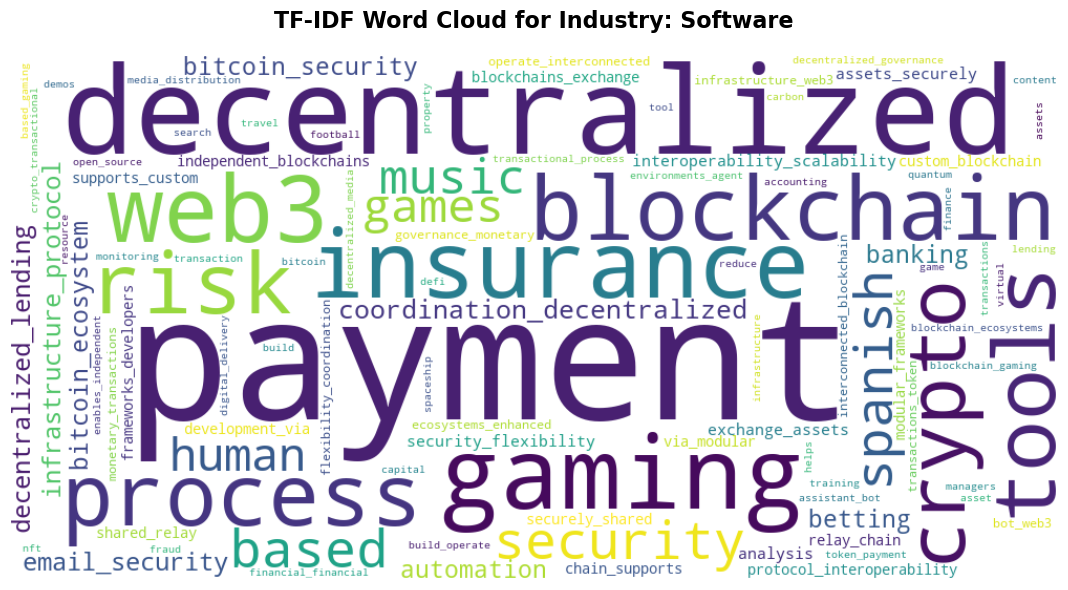


Industry: Software
Total unique words: 215354
Number of investors: 15490
Top 10 TF-IDF words: ['payment', 'decentralized', 'gaming', 'insurance', 'web3', 'blockchain', 'process', 'tools', 'risk', 'crypto']
--------------------------------------------------------------------------------


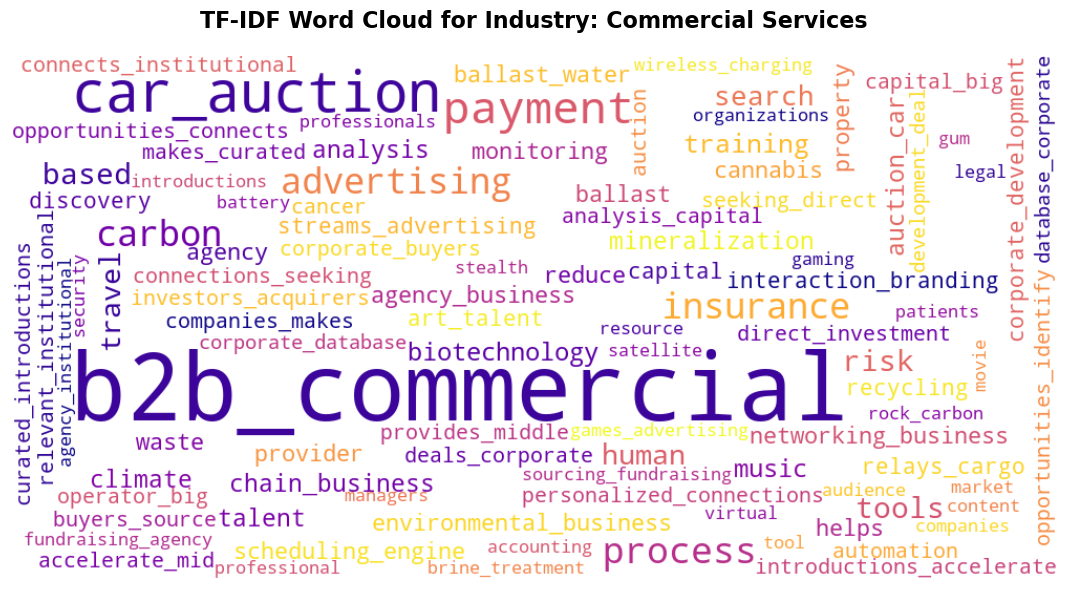


Industry: Commercial Services
Total unique words: 181901
Number of investors: 4075
Top 10 TF-IDF words: ['b2b_commercial', 'car_auction', 'payment', 'process', 'insurance', 'advertising', 'carbon', 'based', 'risk', 'tools']
--------------------------------------------------------------------------------


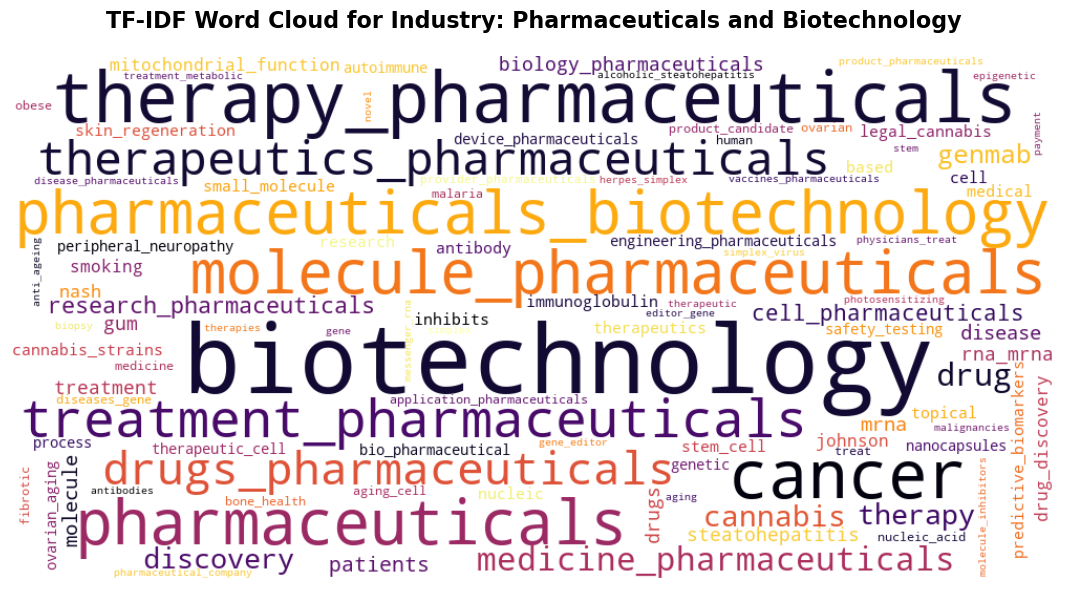


Industry: Pharmaceuticals and Biotechnology
Total unique words: 145372
Number of investors: 2357
Top 10 TF-IDF words: ['biotechnology', 'therapy_pharmaceuticals', 'cancer', 'pharmaceuticals', 'pharmaceuticals_biotechnology', 'molecule_pharmaceuticals', 'treatment_pharmaceuticals', 'therapeutics_pharmaceuticals', 'drugs_pharmaceuticals', 'medicine_pharmaceuticals']
--------------------------------------------------------------------------------


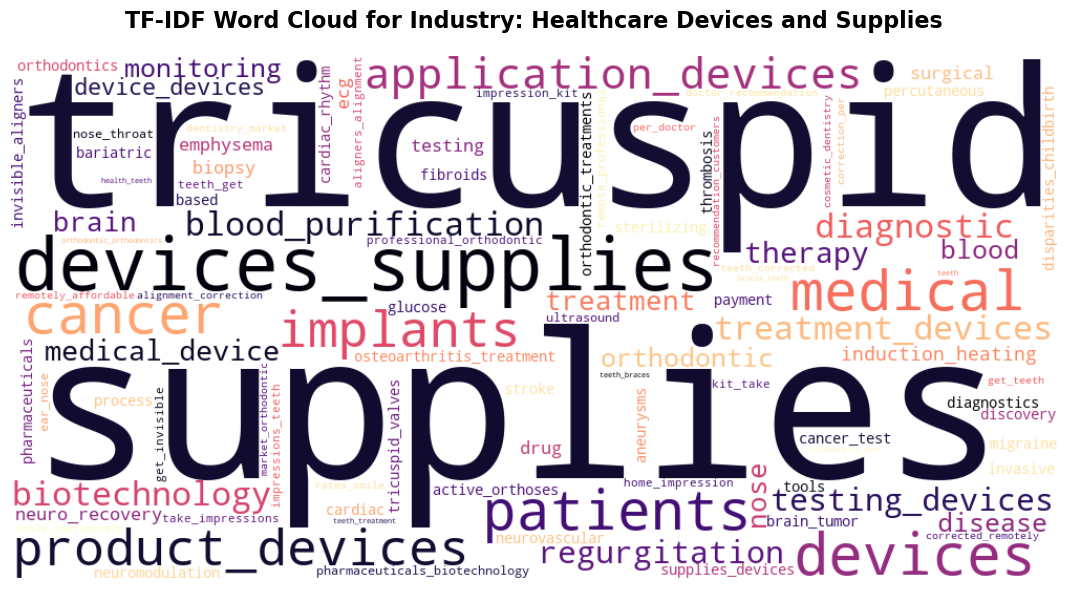


Industry: Healthcare Devices and Supplies
Total unique words: 142039
Number of investors: 1942
Top 10 TF-IDF words: ['supplies', 'tricuspid', 'devices_supplies', 'devices', 'cancer', 'medical', 'patients', 'product_devices', 'implants', 'application_devices']
--------------------------------------------------------------------------------


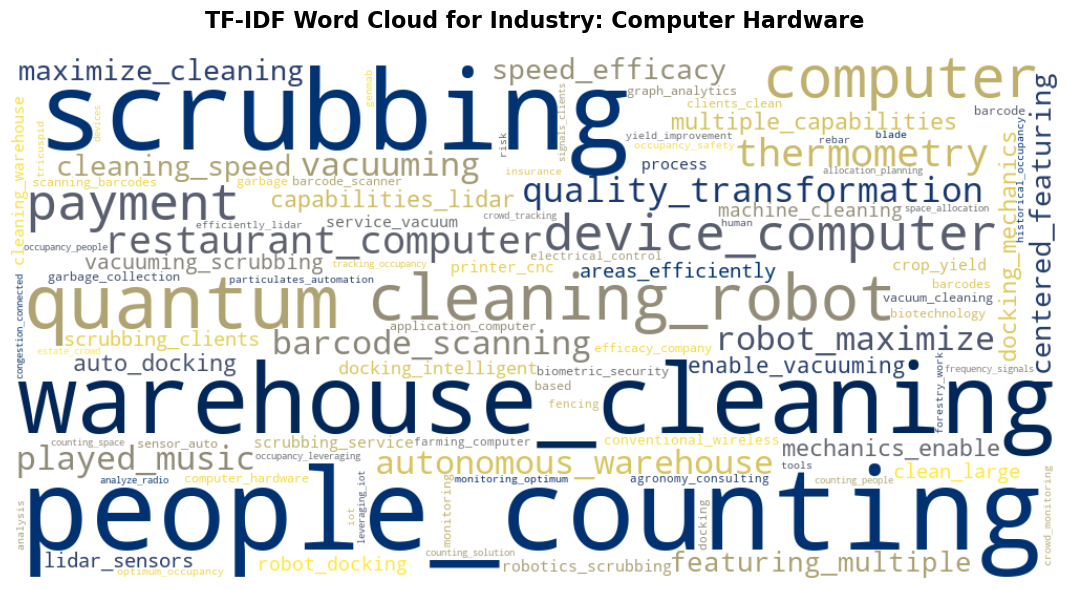


Industry: Computer Hardware
Total unique words: 146847
Number of investors: 1931
Top 10 TF-IDF words: ['people_counting', 'scrubbing', 'warehouse_cleaning', 'quantum', 'cleaning_robot', 'computer', 'payment', 'device_computer', 'restaurant_computer', 'thermometry']
--------------------------------------------------------------------------------


In [93]:
def create_industry_wordcloud(industry_name, tf_idf_dict, colormap='viridis'):
    """
    Create a word cloud for an industry using TF-IDF scores.
    
    Args:
        industry_name: Name of the industry
        tf_idf_dict: TF-IDF scores for this industry
        colormap: Color scheme for the word cloud
    """
    if not tf_idf_dict:
        print(f"No TF-IDF data for industry: {industry_name}")
    
        return
    
    # Create WordCloud object
    wordcloud = WordCloud(
        width=1000,
        height=500,
        background_color='white',
        colormap=colormap,
        collocations=False,
        max_words=100,
        relative_scaling=1,
        random_state=42
    ).generate_from_frequencies(tf_idf_dict)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'TF-IDF Word Cloud for Industry: {industry_name}', 
              fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    top_tfidf = sorted(tf_idf_dict.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\nIndustry: {industry_name}")
    print(f"Total unique words: {len(tf_idf_dict)}")
    print(f"Number of investors: {len(industry_communities[industry_name])}")
    print(f"Top 10 TF-IDF words: {[word for word, _ in top_tfidf]}")
    print("-" * 80)

# Create word clouds for top 7 industries
print("\n" + "="*80)
print("CREATING TF-IDF WORD CLOUDS FOR TOP INDUSTRIES")
print("="*80)

# Color schemes for variety
color_schemes = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'twilight', 'turbo']

# Create word clouds for each top industry
for i, industry in enumerate(top_industries[0:5]):
    if industry in tf_idf_scores:
        colormap = color_schemes[i % len(color_schemes)]
        create_industry_wordcloud(industry, tf_idf_scores[industry], colormap)

#### Visualization of the communities by TF-IDF

Here we try to visualize how well the TF_IDF keywords represent each industry group. We first try PCA to reduce the dimensionality of the TF_IDF vectors to 2D, but the results are not very clear.

This is why later we use TruncatedSVD (which is similar to PCA but works better with sparse data) to reduce the TF_IDF vectors to 2D for visualization. In this case we obtain better results and we see that TF IDF keywords can cluster industries meaningfully.

Variance explained by first component: 0.336
Variance explained by second component: 0.281


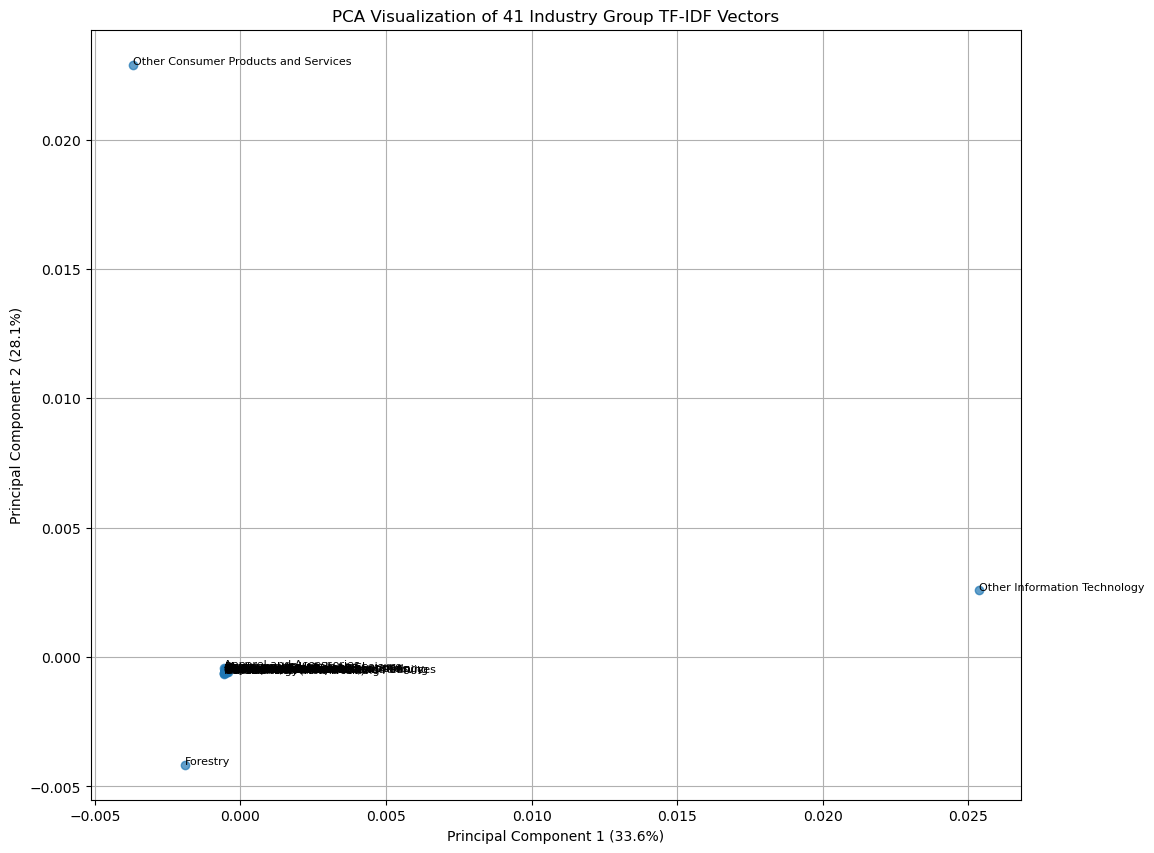

In [94]:
# 1) Gather all unique words (the columns of your final matrix)
global_features = set()
for industry, scores in tf_idf_scores.items():
    global_features.update(scores.keys())

# 2) Create an ordered list of the features
sorted_features = sorted(list(global_features))
group_names = list(tf_idf_scores.keys()) # Your row names (41 groups)

# Initialize an empty list to hold the feature vectors (one per industry)
matrix_rows = []

# 3) Build the rows
for group_name in group_names:
    group_scores = tf_idf_scores[group_name]
    
    # Create a vector for this group
    feature_vector = []
    
    # Iterate through the global, ordered list of features
    for feature in sorted_features:
        # If the feature is present in the group's scores, use its score; otherwise, use 0
        score = group_scores.get(feature, 0.0) 
        feature_vector.append(score)
        
    matrix_rows.append(feature_vector)

# 4. Convert the list of lists into a NumPy array
X_tfidf = np.array(matrix_rows)

# 1. Apply PCA to reduce to 2 components (2D visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf)

# Check how much variance is retained (important validation)
print(f"Variance explained by first component: {pca.explained_variance_ratio_[0]:.3f}")
print(f"Variance explained by second component: {pca.explained_variance_ratio_[1]:.3f}")

# 3. Create the PCA plot
plt.figure(figsize=(12, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)

# Optional: Annotate the points with the group names
for i, name in enumerate(group_names):
    # Only label a subset of points if 41 labels is too cluttered
    #if i % 2 == 0: # Label every second group, for instance
    plt.annotate(name, (X_pca[i, 0], X_pca[i, 1]), fontsize=8)

plt.title('PCA Visualization of 41 Industry Group TF-IDF Vectors')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.grid(True)
plt.show()

Data shape: 41 x 235648  |  sparsity: 0.662
Using TruncatedSVD (suitable for sparse / high-dim TF-IDF).
Variance explained by first component: 0.043
Variance explained by second component: 0.074


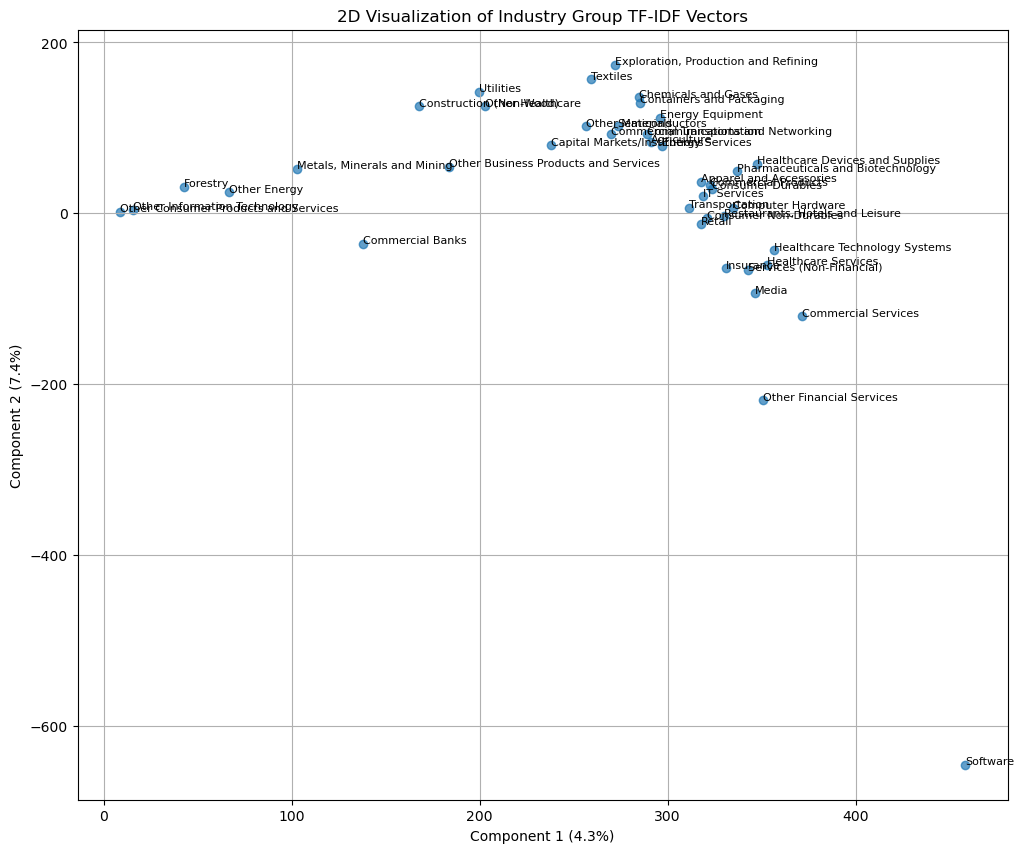

In [ ]:
n_samples, n_features = X_tfidf.shape

# compute sparsity ratio
if isinstance(X_tfidf, np.ndarray):
    zero_count = np.count_nonzero(X_tfidf == 0)
    sparsity = zero_count / X_tfidf.size
else:
    # if already sparse matrix
    sparsity = 1.0 - (X_tfidf.count_nonzero() / (n_samples * n_features))

print(f"Data shape: {n_samples} x {n_features}  |  sparsity: {sparsity:.3f}")

use_truncated_svd = (sparsity > 0.6) or (n_features > 2000)  

n_components = 2

if use_truncated_svd:
    print("Using TruncatedSVD (suitable for sparse / high-dim TF-IDF).")
    # convert to sparse if not already
    X_sparse = sparse.csr_matrix(X_tfidf) if not sparse.issparse(X_tfidf) else X_tfidf
    # Optional: scale (with_mean=False) for sparse data
    scaler = StandardScaler(with_mean=False)
    X_scaled = scaler.fit_transform(X_sparse)
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_2d = svd.fit_transform(X_scaled)
    var_explained = svd.explained_variance_ratio_
else:
    print("Using PCA on dense data (scaled).")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_tfidf)
    pca = PCA(n_components=n_components, random_state=42)
    X_2d = pca.fit_transform(X_scaled)
    var_explained = pca.explained_variance_ratio_

print(f"Variance explained by first component: {var_explained[0]:.3f}")
print(f"Variance explained by second component: {var_explained[1]:.3f}")

# Plot
plt.figure(figsize=(12, 10))
plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.7)

# Annotate with group names (safe indexing)
for i, name in enumerate(group_names):
    if i < X_2d.shape[0]: #and i % 2 == 0:  # Label every second group to reduce clutter
        plt.annotate(name, (X_2d[i, 0], X_2d[i, 1]), fontsize=8)

plt.title('2D Visualization of Industry Group TF-IDF Vectors')
plt.xlabel(f'Component 1 ({var_explained[0]*100:.1f}%)')
plt.ylabel(f'Component 2 ({var_explained[1]*100:.1f}%)')
plt.grid(True)
plt.show()

## Matching companies to interested investors

#### Here we start the recommendation system

The process is as follows: 

- First, we have a **Thematic Matching**, which is computed inside *get_top_matched_groups_manual()*
- Second, we have the **Structural Ranking**, which is computed inside *recommend_investors_personalized()*

The **Thematic Matching** works as follows: 

1. We take as input the new company description and we preprocess it following the same steps we used before to process each investor's portfolio.
2. Then, we vectorize the preprocessed company text into a vector taking into account the exact same vocabulary, n‑gram construction and IDF weights used to build the industry TF‑IDF matrix (i.e., use the same sorted_features and idf_scores). This ensures the company vector lives in the same feature space as X_tfidf.
3. We compute cosine similarity between the company TF‑IDF vector and each industry TF‑IDF row in X_tfidf to obtain a similarity score per industry group.
4. We rank industry groups by similarity and return the top N best‑matching industry groups.
5. These top matched industry groups are then passed to the Structural Ranking stage to filter and score candidate investors. 

In [98]:
# --- PREPROCESSING & VECTORIZATION FUNCTIONS ---

def preprocess_company_text(text, all_stop_words):
    """Applies the identical cleaning, stop word removal, and tokenization/n-gram generation."""
    
    # 1. Cleaning and Tokenization (must match preprocess_portfolio_descriptions_to_tf)
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    tokens = text.split()
    
    clean_tokens = []
    for token in tokens:
        token = token.strip()
        # Ensure identical stop word and length filtering
        if token and token not in all_stop_words and len(token) >= 3:
            clean_tokens.append(token)
    
    return generate_ngrams(clean_tokens, n=2)


def manual_vectorize_company(cleaned_ngrams, sorted_features, idf_scores):
    """
    Converts a list of company n-grams into a (1 x N) TF-IDF vector 
    aligned with the sorted_features list, using Standard Normalized TF.
    """
    
    tf_counts = Counter(cleaned_ngrams)
    company_vector = np.zeros(len(sorted_features))
    
    total_words = len(cleaned_ngrams)
    if total_words == 0:
        return company_vector.reshape(1, -1)
    
    for i, feature in enumerate(sorted_features):
        if feature in tf_counts:
            tf_count = tf_counts[feature]
            
            # Standard Normalized TF = word_count / total_words
            tf = tf_count / total_words
            
            # Retrieve IDF
            idf = idf_scores.get(feature, 0.0)
            
            # Calculate TF-IDF
            company_vector[i] = tf * idf
            
    return company_vector.reshape(1, -1)


In [99]:
# --- THEMATIC MATCHING FUNCTION ---
def get_top_matched_groups_manual(new_company_description, X_tfidf, sorted_features, idf_scores, all_stop_words, group_names, top_n=3):
    
    # 1. Preprocess and get cleaned N-grams
    cleaned_ngrams = preprocess_company_text(new_company_description, all_stop_words)
    
    if not cleaned_ngrams:
        print("Warning: Company description contains no extractable features.")
        return []

    # 2. Manually vectorize the company description
    company_vector = manual_vectorize_company(cleaned_ngrams, sorted_features, idf_scores)
    
    # Check if the vector is all zeros (i.e., no matching vocabulary terms found)
    if np.sum(company_vector) == 0:
        print("Warning: Company vector is all zeros. No matching TF-IDF features found.")
        return []

    # 3. Calculate Cosine Similarity
    similarity_scores = cosine_similarity(company_vector, X_tfidf).flatten()
    
    # 4. Rank and Retrieve Top Matches
    top_indices = np.argsort(similarity_scores)[::-1] 
    top_matches = [(group_names[i], similarity_scores[i]) for i in top_indices[:top_n]]
    
    return top_matches


The **Structural Ranking** works as follows: 

1. We first aggregate candidate investors from the top 3 thematically matched industry groups (we compute the union of investors in those groups).
2. Then, we identify the top-5 Louvain communities that overlap most with this candidate pool, to extract relevant structural communities. After this, we compute a cohesion score for each candidate based on membership/embeddedness in the relevant Louvain communities.
3. Then, we build a candidate-only subgraph from the investor network and compute local centrality (using approx. betweenness) on that subgraph.
5. Then, we apply a generalist penalty using each investor's group_count (number of different industry groups they invest in) so specialists are favored over broad generalists.
6. After this, we apply a lead/sole investor boost using a precomputed normalized lead_score.
7. Finally, we combine signals into a final score:
$$
final\_score = (local\_centrality\_scaled * penalized\_factor) * (1 + \gamma * cohesion\_score) * (1 + \beta * lead\_score\_normalized)
$$
8. And rank candidates by final_score and return the top-10 results

In [100]:
# --- CENTRALITY, COHESION & LOUVAIN COMMUNITIES FUNCTIONS ---

CACHE_DIR = 'centrality_cache'

# Local Centrality Calculation
def get_local_centrality_scores(I_network, candidate_investors):
    """
    Creates a subgraph based on candidate investors from I and calculates local Betweenness Centrality.
    """
    if not candidate_investors:
        return {}

    # 1) Create the subgraph containing only candidate investors
    candidate_set = set(candidate_investors.keys())
    num_nodes = len(candidate_set)

    if num_nodes < 2:
        return {node: 0.0 for node in candidate_set}
    
    sorted_nodes = tuple(sorted(list(candidate_set)))
    subgraph_hash = hashlib.sha256(str(sorted_nodes).encode()).hexdigest()
    cache_filepath = os.path.join(CACHE_DIR, f'{subgraph_hash}.pkl')

    # Ensure the cache directory exists
    os.makedirs(CACHE_DIR, exist_ok=True)

    if os.path.exists(cache_filepath):
        with open(cache_filepath, 'rb') as f:
            return pickle.load(f)
        
    subgraph = I_network.subgraph(candidate_set).copy()
    
    k_samples = min(num_nodes, max(5, int(0.10 * num_nodes)))
    nodes_list = list(subgraph.nodes())
    nodes_to_sample = random.sample(nodes_list, k_samples)
    print(f"    -> Subgraph size: {num_nodes} nodes. Using {k_samples} samples for approximation.")


    # 2. Calculate Betweenness Centrality on the subgraph
    local_centrality = nx.betweenness_centrality_subset(
        subgraph, 
        sources = nodes_to_sample,
        targets = subgraph.nodes(),
        weight='weight', 
        normalized=True
    )

    # Save result to cache before returning
    try:
        with open(cache_filepath, 'wb') as f:
            pickle.dump(local_centrality, f)
    except Exception as e:
        print(f"Warning: Failed to save cache file: {e}")

    return local_centrality


def identify_relevant_louvain_communities(thematic_union_pool, all_louvain_communities, top_k=10):
    """
    Finds the Top K Louvain communities that have the highest overlap with the 
    thematic union pool (investors from the top 3 Industry Groups).
    """
    overlap_list = [] # Stores (overlap_size, louvain_set)
    
    # 1. Calculate overlap for all 3193 Louvain communities
    for louvain_set in all_louvain_communities:
        overlap_size = len(thematic_union_pool.intersection(louvain_set))
        if overlap_size > 0:
            overlap_list.append((overlap_size, louvain_set))
            
    # 2. Sort by overlap size and select Top K
    overlap_list.sort(key=lambda x: x[0], reverse=True)
    
    # Return just the community sets of the top K
    return overlap_list[:top_k]


def calculate_local_cohesion(candidate_investor_id, relevant_louvain_communities):
    """
    Calculates an investor's Cohesion Score based on their structural embeddedness
    in the top-matched Louvain cliques for the current theme.
    
    Score is based on the investor's structural position (membership) relative to 
    the total size of the relevant cliques.
    """
    total_cohesion_score = 0.0
    total_overlap_sizes = sum(item[0] for item in relevant_louvain_communities)
    
    # Check every relevant Louvain community
    for overlap_size, louvain_set in relevant_louvain_communities:
        if candidate_investor_id in louvain_set:
            # If the investor is in this set, their contribution to cohesion 
            # is weighted by the size of the clique. Larger, more robust cliques 
            # offer a higher cohesion signal.
            
            # Use log scaling to avoid clique size completely overwhelming the final score
            score_contribution = math.log1p(len(louvain_set)) 
            max_log_overlap = math.log1p(max(item[0] for item in relevant_louvain_communities))
            total_cohesion_score += (score_contribution / max_log_overlap)
            
    num_contributing_communities = sum(1 for item in relevant_louvain_communities if candidate_investor_id in item[1])
    
    return total_cohesion_score / num_contributing_communities if num_contributing_communities > 0 else 0.0

In [ ]:
# --- STRUCTURAL MATCHING FUNCTION ---

def recommend_investors_personalized(top_matched_groups, group_investor_pools, I_network, all_louvain_communities, num_investors=5):

    candidate_investors_dict = {}
    
    BETA_FACTOR = 0.6 
    GAMMA_COHESION = 0.8
    TOTAL_GROUPS = 41 
    SCORE_SCALER = 10000.0

    # 1. Aggregate ALL candidate investors from the top matched groups
    for group_name, score in top_matched_groups:
        investors = group_investor_pools.get(group_name, [])
        for investor_id in investors:
            candidate_investors_dict[investor_id] = True # Simple placeholder

    relevant_louvain_communities = identify_relevant_louvain_communities(
        set(candidate_investors_dict.keys()), all_louvain_communities, top_k=5
    )
    
    # 2. Calculate LOCAL CENTRALITY
    local_centrality_scores = get_local_centrality_scores(I_network, candidate_investors_dict)

    # 3. Apply GENERALIST PENALTY and Calculate Final Score
    final_scores = {}

    for inv_id in candidate_investors_dict.keys():
        local_score = local_centrality_scores.get(inv_id, 0.0) * SCORE_SCALER
        
        group_count = I_network.nodes[inv_id].get('group_count', 0)
        lead_score_normalized = I_network.nodes[inv_id].get('lead_score_normalized', 0.0)
        
        if group_count <= 1:
            penalized_factor = 1.0 # Specialist (Group Count = 1) receives no penalty
        else:
            scaling_range = TOTAL_GROUPS - 1
            generalist_proportion = (group_count - 1) / scaling_range
            penalized_factor = 1.0 - generalist_proportion
            
        penalized_score = local_score * penalized_factor
        
        cohesion_score = calculate_local_cohesion(inv_id, relevant_louvain_communities)
        cohesion_multiplier = 1 + (GAMMA_COHESION * cohesion_score)

        boost_multiplier = 1 + (BETA_FACTOR * lead_score_normalized)

        final_score = penalized_score * cohesion_multiplier * boost_multiplier

        final_scores[inv_id] = final_score

    # 4. Rank candidates by the Final Penalized Score
    final_ranked_investors = sorted(
        final_scores.items(), 
        key=lambda item: item[1], 
        reverse=True
    )
    
    return final_ranked_investors[:num_investors]

This function runs the full recommendation pipeline. 

In [102]:
def run_full_recommendation_pipeline_manual(new_company_description, X_tfidf, sorted_features, idf_scores, all_stop_words, group_names, group_investor_pools):
    """
    Executes the full process using manual vectorization.
    """
    print(f"==================================================")
    print(f"🎯 Starting Recommendation for New Company")
    print(f"Description: '{new_company_description[:50]}...'")
    print(f"Total features used for matching: {len(sorted_features)}")
    print(f"==================================================")
    
    # --- STEP 1: Thematic Matching ---
    top_groups = get_top_matched_groups_manual(
        new_company_description, 
        X_tfidf, 
        sorted_features, 
        idf_scores, 
        all_stop_words, 
        group_names, 
        top_n=3
    )
    
    if not top_groups:
        return "Recommendation failed: No matching vocabulary found."
    
    print("\n✅ Thematic Match Complete.")
    print("Top 3 Best Matched Industry Groups:")
    for name, score in top_groups:
        print(f"  - {name} (Similarity: {score:.4f})")
    
    
    # --- STEP 2: Structural Ranking ---
    final_recommendations = recommend_investors_personalized(
        top_groups, 
        group_investor_pools, 
        I, 
        all_louvain_communities=louvain_comms,
        num_investors=10
    )
    
    print("\n✅ Structural Ranking Complete.")
    

    # --- STEP 3: Display Final Recommendations ---
    print("\nRanking | Investor ID | Final Score (Local & Penalized) | Group Count")
    print("-" * 70)
    for rank, (inv_id, score) in enumerate(final_recommendations, 1):
        group_count = I.nodes[inv_id].get('group_count', 0)
        lead_count = I.nodes[inv_id].get('lead_sole_count', 0)
        print(f"{rank:<7} | {inv_id:<11}... | {score:.6f} | {group_count} | {lead_count}")
        
    print("\n==================================================")
    print("Recommendation Pipeline Finished.")

    return final_recommendations, top_groups
    

Here, we create two test cases to see how well the designed recommendation pipeline works.

We assume it works well because before appliying the composite score, the pipeline would just recomend the top investors (the ones who have invested in most companies) but, after it, we see that other investors less central but more specialized emerge. 

In [114]:
# --- TEST CASE 1: FINANCIAL TECHNOLOGY ---
new_company_text_1 = "Venture for a new B2B payments application running on blockchain architecture for small enterprises, focused on high compliance standards."
print("=" * 60)
print("TEST CASE 1: B2B Payments / Blockchain")
print("=" * 60)
final_recommendations, top_groups = run_full_recommendation_pipeline_manual(
    new_company_text_1, 
    X_tfidf, 
    sorted_features, 
    idf_scores, 
    all_stop_words, 
    group_names, 
    industry_communities
)

TEST CASE 1: B2B Payments / Blockchain
🎯 Starting Recommendation for New Company
Description: 'Venture for a new B2B payments application running...'
Total features used for matching: 235648

✅ Thematic Match Complete.
Top 3 Best Matched Industry Groups:
  - Energy Equipment (Similarity: 0.0107)
  - Software (Similarity: 0.0071)
  - Other Financial Services (Similarity: 0.0061)

✅ Structural Ranking Complete.

Ranking | Investor ID | Final Score (Local & Penalized) | Group Count
----------------------------------------------------------------------
1       | Patrick Brooks... | 75.140638 | 27 | 4
2       | Cole Pollard... | 33.710575 | 17 | 1
3       | Logan Barrett... | 33.387663 | 10 | 5
4       | Harold Reynolds... | 29.753826 | 16 | 0
5       | Kent Dragomir... | 25.902418 | 21 | 0
6       | Dylan Galanis... | 24.445095 | 15 | 3
7       | Harvey Bauer... | 23.829641 | 12 | 3
8       | Ronald Papadakis... | 22.012581 | 26 | 10
9       | Eduardo Todorov... | 21.994005 | 5 | 0
10     

In [115]:
# see node attributes of top recommended investors
print(top_groups)
print("\nTop Recommended Investors' Attributes:")
for inv_id, score in final_recommendations:
    attrs = I.nodes[inv_id]
    print(f"Investor ID: {inv_id}")
    # print attribute industry_investments
    industry_investments = attrs.get('industry_investments', {})
    print(f"  Industry Investments: {industry_investments}")
    print("-" * 40)

[('Energy Equipment', np.float64(0.010740551285637535)), ('Software', np.float64(0.007125131390730011)), ('Other Financial Services', np.float64(0.006092453174870431))]

Top Recommended Investors' Attributes:
Investor ID: Patrick Brooks
  Industry Investments: {'Software': 112, 'Insurance': 4, 'Pharmaceuticals and Biotechnology': 7, 'Exploration, Production and Refining': 3, 'Commercial Services': 37, 'Computer Hardware': 17, 'Healthcare Services': 7, 'Other Materials': 3, 'Services (Non-Financial)': 2, 'Other Financial Services': 3, 'Consumer Durables': 3, 'Energy Services': 6, 'Healthcare Devices and Supplies': 7, 'Consumer Non-Durables': 4, 'Apparel and Accessories': 1, 'Commercial Products': 9, 'IT Services': 1, 'Healthcare Technology Systems': 13, 'Media': 4, 'Agriculture': 3, 'Restaurants, Hotels and Leisure': 1, 'Transportation': 2, 'Chemicals and Gases': 2, 'Commercial Transportation': 2, 'Textiles': 1, 'Energy Equipment': 3, 'Containers and Packaging': 3}
---------------------

In [116]:
# --- TEST CASE 2: BIOTECHNOLOGY ---
new_company_text_2 = "SaaS platform offering real-time remote patient monitoring and predictive analytics to reduce hospital readmission rates for chronic heart failure patients."
print("=" * 60)
print("TEST CASE 2: Gene Therapy / Diagnostics")
print("=" * 60)
final_recommendations, top_groups = run_full_recommendation_pipeline_manual(
    new_company_text_2, 
    X_tfidf, 
    sorted_features, 
    idf_scores, 
    all_stop_words, 
    group_names, 
    industry_communities
)

TEST CASE 2: Gene Therapy / Diagnostics
🎯 Starting Recommendation for New Company
Description: 'SaaS platform offering real-time remote patient mo...'
Total features used for matching: 235648

✅ Thematic Match Complete.
Top 3 Best Matched Industry Groups:
  - Healthcare Devices and Supplies (Similarity: 0.0196)
  - Healthcare Technology Systems (Similarity: 0.0093)
  - Pharmaceuticals and Biotechnology (Similarity: 0.0067)

✅ Structural Ranking Complete.

Ranking | Investor ID | Final Score (Local & Penalized) | Group Count
----------------------------------------------------------------------
1       | Patrick Brooks... | 65.567041 | 27 | 4
2       | Sullivan Horvat... | 46.702573 | 18 | 1
3       | Logan Boone... | 36.834625 | 10 | 0
4       | Rodrigo Calhoun... | 30.283922 | 12 | 10
5       | Samuel Reese... | 29.785649 | 10 | 1
6       | Billy Allen... | 27.850015 | 12 | 1
7       | Ronald Papadakis... | 26.577806 | 26 | 10
8       | Brandon Wilson... | 25.388893 | 14 | 8
9       |

In [117]:
# see node attributes of top recommended investors
print("\nTop Recommended Investors' Attributes:")
for inv_id, score in final_recommendations:
    attrs = I.nodes[inv_id]
    print(f"Investor ID: {inv_id}")
    # print attribute industry_investments
    industry_investments = attrs.get('industry_investments', {})
    print(f"  Industry Investments: {industry_investments}")
    print("-" * 40)


Top Recommended Investors' Attributes:
Investor ID: Patrick Brooks
  Industry Investments: {'Software': 112, 'Insurance': 4, 'Pharmaceuticals and Biotechnology': 7, 'Exploration, Production and Refining': 3, 'Commercial Services': 37, 'Computer Hardware': 17, 'Healthcare Services': 7, 'Other Materials': 3, 'Services (Non-Financial)': 2, 'Other Financial Services': 3, 'Consumer Durables': 3, 'Energy Services': 6, 'Healthcare Devices and Supplies': 7, 'Consumer Non-Durables': 4, 'Apparel and Accessories': 1, 'Commercial Products': 9, 'IT Services': 1, 'Healthcare Technology Systems': 13, 'Media': 4, 'Agriculture': 3, 'Restaurants, Hotels and Leisure': 1, 'Transportation': 2, 'Chemicals and Gases': 2, 'Commercial Transportation': 2, 'Textiles': 1, 'Energy Equipment': 3, 'Containers and Packaging': 3}
----------------------------------------
Investor ID: Sullivan Horvat
  Industry Investments: {'Healthcare Devices and Supplies': 21, 'Commercial Services': 4, 'Semiconductors': 5, 'Energy E